# Notebook Learning Goals:
1. Basics of a data pipelines framework (Luigi).
2. Understand the importance of designing your data model and pipelines in a scalable way.
3. Be aware of some of some of the idiosyncrasies coming from data, and how our designs should tackle them.

# **0. Install Luigi**

## Officially, what is Luigi?
Luigi is a python package that helps you build data pipelines. *It handles dependency resolution, workflow management, visualization, handling failures, command line integration, and much more.* 

## What does this actually mean?

The point of Luigi (or any pipeline package) is to handle the workflows associated with data -- like our sandwich example, once we're going from making 1 sandwich 1 time, to 100000 sandwiches every day, we need some tools to make sure things are tracked, automated, and run. It helps you connect a variety of tasks -- getting data from different places, modifying the data via SQL queries run on Hive/Presto/Spark etc, maybe running some custom code, and putting this finalized data into a new place!

In [ ]:
!pip install luigi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 8.2 MB/s 
  Created wheel for luigi: filename=luigi-3.1.0-py3-none-any.whl size=1082166 sha256=1e5bc9521884bfbc492a56288736a9ac77105ec1748b4db779b90b01662d74f9
  Stored in directory: /root/.cache/pip/wheels/27/41/3b/a16640f9d0d247f7c160f388183acc38487014956535736a9e
Successfully built luigi


# **0.1 lab_params.py**

In this file, we define some parameters and file paths

In [ ]:
#!/usr/bin/env python

import os

DB_NAME = 'dsa.db'

# File paths
RAW_DATA_FOLDER_PATH = 'raw_data'
MOVE_RANGE_FILE_PATH = os.path.join(RAW_DATA_FOLDER_PATH ,'movement-range-2021-09-09.txt')
COUNTRY_REGION_FILE_PATH = os.path.join(MOVE_RANGE_FILE_PATH , 'country_regions.txt')

# Table names
# TEST_PREFIX=''
# MOVE_RANGE_TABLE_NAME = f'{TEST_PREFIX}rpl_move_range'
# COVID_SURVEY_TABLE_NAME = f'{TEST_PREFIX}rpl_covid_survey'

# Time range (for COVID survey API)
# FROM_DATE = '2021-01-01'
# TO_DATE = '2021-06-30'

# Other parameters
INDICATORS = [
    'covid',
    'mask',
    'covid_vaccine',
    'anosmia',
]

COUNTRIES = ['Japan', 'Switzerland', 'Kenya', 'Algeria', 'Spain', 'Argentina', 'Poland', 'South Africa']

In [ ]:
import requests 
import json
import pandas as pd

# request data from api
response = requests.get("https://covidmap.umd.edu/api/country").text
print("API call finished")

# convert json data to dictionary
response_dict = json.loads(response)

# convert to pandas dataframe
ALL_COUNTRIES = pd.DataFrame.from_dict(response_dict['data'])['country']

API call finished


# **0.2 lab_utils.py**

Here we define some helper functions for our notebook

In [ ]:
#!/usr/bin/env python

import pandas as pd
import luigi
import sqlite3
import csv


# Returns objects to interact with database
def connect_db():
    conn = sqlite3.connect(DB_NAME)
    cur = conn.cursor()
    return conn, cur


# Creates empty table in database
def create_table(table_name, table_schema, drop_if_exists=False):
    conn, cur = connect_db()
    cols = ',\n'.join([f'{col_name} {col_type}' for col_name, col_type in table_schema])
    
    if drop_if_exists:
        sql = f'DROP TABLE IF EXISTS {table_name};'
        print(sql)
        print('\n\n')
        cur.execute(sql)

    sql = f"""
        CREATE TABLE IF NOT EXISTS {table_name}(
            {cols}
        );
    """
    print(sql)
    print('\n\n')
    cur.execute(sql)
    conn.commit()
    conn.close()


# Loads data from file to table in database
def load_file_in_table(
    file_path,
    table_name,
    table_schema=None,
    sep='\t',
    skip_header=True,
    file_encoding='utf-8',
    run_create_table=False,
    overwrite_filter=None,
):
    conn, cur = connect_db()
    
    if run_create_table:
        create_table(table_name, table_schema)
    
    if overwrite_filter:
        sql = f'DELETE FROM {table_name} WHERE {overwrite_filter}'
        print(sql)
        cur.execute(sql)
        print('\n\n')

    print('-----------------------\nFile loading: STARTED\n-----------------------\n')
    insert_statement = f"INSERT INTO {table_name} ({', '.join([col[0] for col in table_schema])}) VALUES({', '.join(['?' for col in table_schema])})"
    print(insert_statement)
    df = pd.read_csv(file_path, sep=sep)
    df.to_sql(table_name, con=conn, if_exists='append', index=False)
    conn.close()
    print('-----------------------\nFile loading: FINISHED\n-----------------------\n')


# Runs query on database, returns output as pandas.DataFrame
def query_db(query):
    conn, cur = connect_db()
    output = pd.io.sql.read_sql_query(query, conn)
    conn.close()
    return output


# Runs query, returns nothing
def run_query(query, verbose=False):
    conn, cur = connect_db()
    if verbose:
        print(query)
    cur.execute(query)
    conn.commit()
    conn.close()


# Returns a dataframe listing all tables in database
def get_tables_list():
    return query_db("SELECT name FROM sqlite_master WHERE type='table'")


# Returns True if table exists, False otherwise
def table_exists(table_name):
    return table_name in set(get_tables_list()["name"])


# ##########################
# Luigi auxiliary utilities
# ##########################

class TableExists(luigi.Target):
    def __init__(self, table_name):
        super().__init__()
        self.table_name = table_name

    def exists(self):
        return table_exists(self.table_name)


class DataExists(luigi.Target):
    def __init__(self, table_name, where_clause):
        super().__init__()
        self.table_name = table_name
        self.where_clause = where_clause

    def exists(self):
        if TableExists(self.table_name).exists():
            print(f'LOGGING: Table exists: {self.table_name}')
            return query_db(f'SELECT * FROM {self.table_name} WHERE {self.where_clause} LIMIT 1').size > 0
        else:
            return False


class DummyOutput(luigi.Target):
    def __init__(self, dummy_variable=False):
        super().__init__()
        self.dummy_variable = dummy_variable

    def exits(self):
        print(f'DummyOutput: {self.dummy_variable}')
        if self.dummy_variable:
            return True
        else:
            return False


# #########################
# Other auxiliary functions
# #########################

def get_indicator_code(indicator):
    indicator_to_code = {
        'flu': 'ili',
        'mask': 'mc',
        'contact': 'dc',
        'finance': 'hf',
        'anosmia': 'anos',
        'vaccine_acpt': 'vu',
    }
    return indicator_to_code.get(indicator, indicator)


def get_pct_prefix(indicator):
    pct_indicators = [
        "covid",
        "tested_positive_14d",
        "covid_vaccine",
    ]
    if indicator in pct_indicators:
        return "pct"
    else:
        return "percent"


# **1. Pipeline 1: Download daily reports from API**

You can think of a data pipeline as a DAG (directed acyclic graph). This will make a lot more sense once we explain the pipeline 

The first pipeline that we're going to be looking at in this notebook has 4 tasks: 

1) DowloadAPIReport(): Download the data for a specific country+indicator pair from the API to a text file 

2) CreateTable(): Create a table in the database for a specific indicator.

3) LoadReportIntoDB(): Load the data from the text file into the database.

4) MasterTask(): A task to kick off all the various other tasks and provide input parameters

In this scenario, for a basic pipeline run, the DAG is:

 Create------> Load. --> Master

 Download-^     

A DAG is basically a graph where the connections between nodes have directions, and there's no circles in the graph.

Imagine if you tried to run the Load before the Create -- the task would fail since we don't have a table schema for the data to be loaded into! 

However, you can see that in the Master Task (or in the logs!) we're actually generating 4 Creates, 8 Downloads, and 8 Loads -- because we're running the tasks for 4 indicators and 2 countires! Imagine having to do this by hand. 
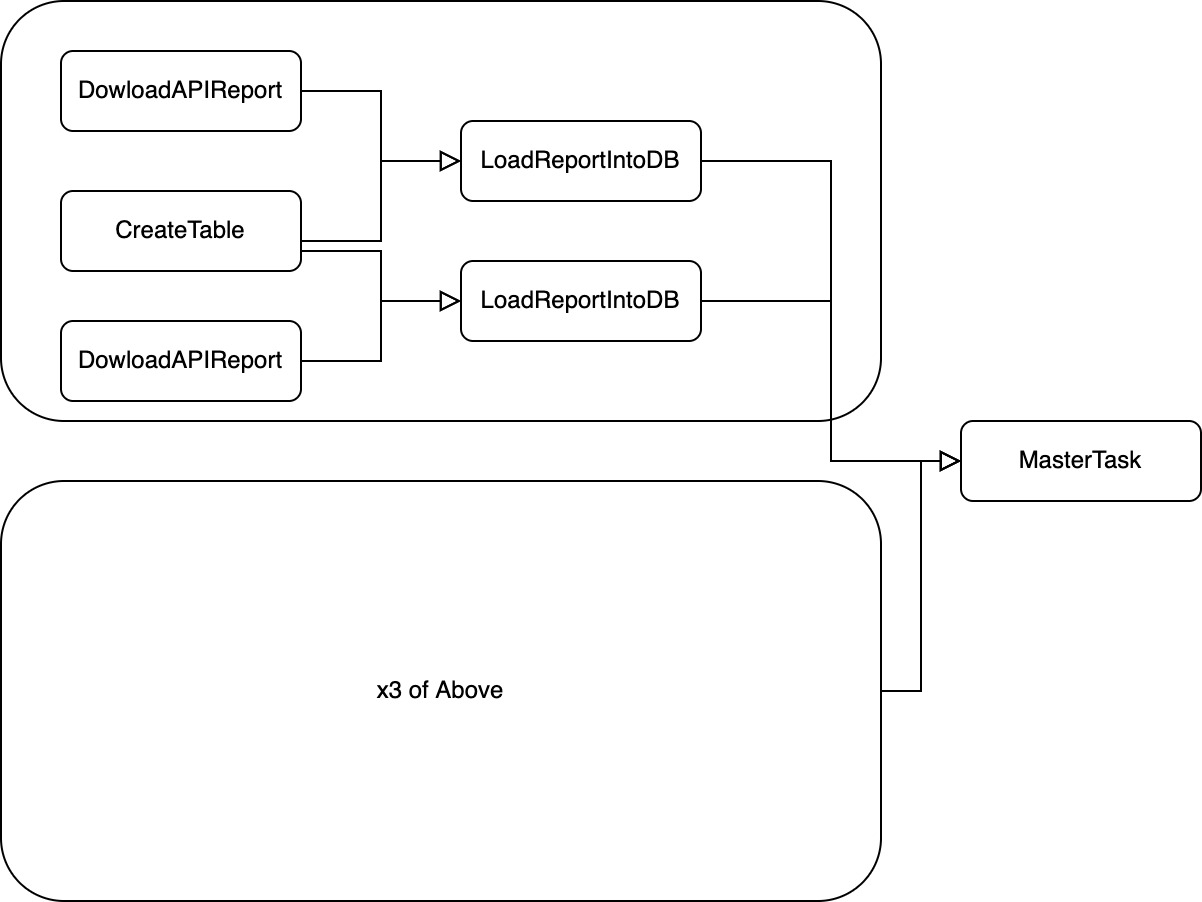

Dags can get complicated and pipelines can run for weeks -- the most complicated pipeline (AND REALLY BAD) Neil worked on spun up 8000 tasks and ran for 4 days per 1 days data! 

In [ ]:
#!/usr/bin/env python

import luigi
import requests
import json
import os
import pandas as pd


# ###################
# AUXILIARY FUNCTIONS
# ###################

# Renders the file path for the report to download
def get_file_path(indicator, country, date):
    date_no_dash = date.replace('-', '')
    return os.path.join(RAW_DATA_FOLDER_PATH, f'covid_survey__{indicator}__{country}__{date_no_dash}__{date_no_dash}.txt')

# Renders the table name for each different indicator
def get_rpl_covid_survey_table_name(indicator, test_prefix):
    return f'{test_prefix}rpl_covid_survey_{indicator}'


# ##############
# PIPELINE TASKS
# ##############

class CreateTable(luigi.Task):
    """
    Creates table in database.
    """
    test_prefix = luigi.Parameter(default='')
    indicator = luigi.Parameter()

    def run(self):
        indicator_code = get_indicator_code(self.indicator)
        percent = get_pct_prefix(self.indicator)
        table_schema = (
            (f'{percent}_{indicator_code}', 'float'),
            (f'{indicator_code}_se', 'float'),
            (f'{percent}_{indicator_code}_unw', 'float'),
            (f'{indicator_code}_se_unw', 'float'),
            ('sample_size', 'NUMERIC'),
            ('country', 'text'),
            ('iso_code', 'text'),
            ('gid_0', 'text'),
            ('survey_date', 'NUMERIC'),
        )
        create_table(get_rpl_covid_survey_table_name(self.indicator, self.test_prefix), table_schema)

    def output(self):
        return TableExists(get_rpl_covid_survey_table_name(self.indicator, self.test_prefix))


class DownloadAPIReport(luigi.Task):
    """
    Downloads report from API.
    """
    indicator = luigi.Parameter()
    country = luigi.Parameter()
    date = luigi.Parameter()

    def run(self):
        # Create folder is not existing
        if RAW_DATA_FOLDER_PATH not in os.listdir():
            os.mkdir(RAW_DATA_FOLDER_PATH)
        file_path = get_file_path(self.indicator, self.country, self.date)
        # Get params for API call
        date_no_dash = self.date.replace('-', '')
        url = f"https://covidmap.umd.edu/api/resources?indicator={self.indicator}&type=daily&country={self.country}&daterange={date_no_dash}-{date_no_dash}"
        # Call API and save respond in CSV
        print("CALLING API: ", url)
        response = requests.get(url).text
        response_dict = json.loads(response)
        df = pd.DataFrame.from_dict(response_dict['data'])
        df.to_csv(file_path, sep='\t', index=False, encoding='utf-8')

    def output(self):
        file_path = get_file_path(self.indicator, self.country, self.date)
        return luigi.LocalTarget(file_path)
        

class LoadReportIntoDB(luigi.Task):
    """
    Loads report file into database.
    """
    test_prefix = luigi.Parameter(default='')
    indicator = luigi.Parameter()
    country = luigi.Parameter()
    date = luigi.Parameter()

    def get_sql_filter(self):
        return f"country='{self.country}' AND survey_date = {self.date.replace('-','')}"

    def requires(self):
        yield DownloadAPIReport(indicator=self.indicator, country=self.country, date=self.date)
        yield CreateTable(indicator=self.indicator, test_prefix=self.test_prefix)

    def run(self):
        file_path = get_file_path(self.indicator, self.country, self.date)
        indicator_code = get_indicator_code(self.indicator)
        percent = get_pct_prefix(self.indicator)
        table_schema = (
            (f'{percent}_{indicator_code}', 'float'),
            (f'{indicator_code}_se', 'float'),
            (f'{percent}_{indicator_code}_unw', 'float'),
            (f'{indicator_code}_se_unw', 'float'),
            ('sample_size', 'NUMERIC'),
            ('country', 'text'),
            ('iso_code', 'text'),
            ('gid_0', 'text'),
            ('survey_date', 'NUMERIC'),
        )
        load_file_in_table(
            file_path,
            get_rpl_covid_survey_table_name(self.indicator, self.test_prefix),
            table_schema=table_schema,
            overwrite_filter=self.get_sql_filter(),
            skip_header=True,
        )

    def output(self):
        return DataExists(
            table_name=get_rpl_covid_survey_table_name(self.indicator, self.test_prefix),
            where_clause=self.get_sql_filter()
        )


class MasterTask(luigi.WrapperTask):
    """
    Generates tasks for several survey indicators and countries.
    """
    test_prefix = luigi.Parameter(default='')
    date = luigi.Parameter()

    def requires(self):
        for indicator in INDICATORS:
            for country in COUNTRIES:
                yield LoadReportIntoDB(indicator=indicator, country=country, date=self.date, test_prefix=self.test_prefix)
 

DATE = '2021-07-01'
TEST_PREFIX = ''

if __name__ == '__main__':
     luigi.build(
         [MasterTask(
             date=DATE,
             test_prefix=TEST_PREFIX
        )],
         workers=5,
         local_scheduler=True
    )


DEBUG: Checking if MasterTask(test_prefix=, date=2021-07-01) is complete
DEBUG:luigi-interface:Checking if MasterTask(test_prefix=, date=2021-07-01) is complete
DEBUG: Checking if LoadReportIntoDB(test_prefix=, indicator=covid, country=Japan, date=2021-07-01) is complete
DEBUG:luigi-interface:Checking if LoadReportIntoDB(test_prefix=, indicator=covid, country=Japan, date=2021-07-01) is complete
DEBUG: Checking if LoadReportIntoDB(test_prefix=, indicator=covid, country=Switzerland, date=2021-07-01) is complete
DEBUG:luigi-interface:Checking if LoadReportIntoDB(test_prefix=, indicator=covid, country=Switzerland, date=2021-07-01) is complete
DEBUG: Checking if LoadReportIntoDB(test_prefix=, indicator=covid, country=Kenya, date=2021-07-01) is complete
DEBUG:luigi-interface:Checking if LoadReportIntoDB(test_prefix=, indicator=covid, country=Kenya, date=2021-07-01) is complete
DEBUG: Checking if LoadReportIntoDB(test_prefix=, indicator=covid, country=Algeria, date=2021-07-01) is complete
DEB


        CREATE TABLE IF NOT EXISTS rpl_covid_survey_tested_positive_14d(
            pct_tested_positive_14d float,
tested_positive_14d_se float,
pct_tested_positive_14d_unw float,
tested_positive_14d_se_unw float,
sample_size NUMERIC,
country text,
iso_code text,
gid_0 text,
survey_date NUMERIC
        );
    

DEBUG: Pending tasks: 84


DEBUG:luigi-interface:Pending tasks: 84


INFO: [pid 320] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=South Africa, date=2021-07-01)


DEBUG: Asking scheduler for work...
INFO: [pid 317] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=, indicator=tested_positive_14d)
DEBUG:luigi-interface:Asking scheduler for work...
INFO:luigi-interface:[pid 317] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=, indicator=tested_positive_14d)
DEBUG: Pending tasks: 83
INFO:luigi-interface:[pid 320] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=South Africa, date=2021-07-01)
DEBUG:luigi-interface:Pending tasks: 83


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=tested_positive_14d&type=daily&country=South Africa&daterange=20210701-20210701


INFO: [pid 335] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=Poland, date=2021-07-01)
INFO:luigi-interface:[pid 335] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=Poland, date=2021-07-01)
DEBUG: Asking scheduler for work...


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=tested_positive_14d&type=daily&country=Poland&daterange=20210701-20210701


DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 82
DEBUG:luigi-interface:Pending tasks: 82
INFO: [pid 349] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=Argentina, date=2021-07-01)
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO:luigi-interface:[pid 349] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=Argentina, date=2021-07-01)
INFO: Informed scheduler that task   CreateTable_tested_positive___d23bf2962f   has status   DONE


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=tested_positive_14d&type=daily&country=Argentina&daterange=20210701-20210701


INFO:luigi-interface:Informed scheduler that task   CreateTable_tested_positive___d23bf2962f   has status   DONE
INFO: [pid 354] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=Spain, date=2021-07-01)
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 81
INFO:luigi-interface:[pid 354] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=Spain, date=2021-07-01)
DEBUG:luigi-interface:Pending tasks: 81


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=tested_positive_14d&type=daily&country=Spain&daterange=20210701-20210701


DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 363] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=Algeria, date=2021-07-01)
INFO:luigi-interface:[pid 363] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=Algeria, date=2021-07-01)


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=tested_positive_14d&type=daily&country=Algeria&daterange=20210701-20210701


INFO: [pid 320] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=tested_positive_14d, country=South Africa, date=2021-07-01)
INFO:luigi-interface:[pid 320] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=tested_positive_14d, country=South Africa, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_South_Africa_2021_07_01_tested_positive__1f2f135abf   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_South_Africa_2021_07_01_tested_positive__1f2f135abf   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 80
DEBUG:luigi-interface:Pending tasks: 80
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 375] Worker Worker(salt=02210575

DELETE FROM rpl_covid_survey_tested_positive_14d WHERE country='South Africa' AND survey_date = 20210701



-----------------------
File loading: STARTED
-----------------------

INSERT INTO rpl_covid_survey_tested_positive_14d (pct_tested_positive_14d, tested_positive_14d_se, pct_tested_positive_14d_unw, tested_positive_14d_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)
-----------------------
File loading: FINISHED
-----------------------



INFO: [pid 375] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=South Africa, date=2021-07-01)
INFO:luigi-interface:[pid 375] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=South Africa, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_South_Africa_2021_07_01_tested_positive__226391238d   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_South_Africa_2021_07_01_tested_positive__226391238d   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 79
DEBUG:luigi-interface:Pending tasks: 79
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 401] Wor

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=tested_positive_14d&type=daily&country=Kenya&daterange=20210701-20210701


DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 349] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=tested_positive_14d, country=Argentina, date=2021-07-01)
INFO: [pid 354] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=tested_positive_14d, country=Spain, date=2021-07-01)
INFO: [pid 335] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=tested_positive_14d, country=Poland, date=2021-07-01)
INFO: [pid 363] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=tested_positive_14d, country=Algeria, date=2021-07-01)
INFO:luigi-interface:[pid 354] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, 

DELETE FROM rpl_covid_survey_tested_positive_14d WHERE country='Spain' AND survey_date = 20210701


DEBUG: 5 running tasks, waiting for next task to finish


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


INFO: Informed scheduler that task   DownloadAPIReport_Argentina_2021_07_01_tested_positive__cc9351ebe8   has status   DONE


-----------------------
File loading: STARTED
-----------------------


INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Argentina_2021_07_01_tested_positive__cc9351ebe8   has status   DONE
DEBUG: Asking scheduler for work...
INFO: [pid 437] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Poland, date=2021-07-01)
DEBUG:luigi-interface:Asking scheduler for work...


DEBUG: Pending tasks: 76
INFO:luigi-interface:[pid 437] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Poland, date=2021-07-01)
DEBUG:luigi-interface:Pending tasks: 76


INSERT INTO rpl_covid_survey_tested_positive_14d (pct_tested_positive_14d, tested_positive_14d_se, pct_tested_positive_14d_unw, tested_positive_14d_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG: 5 running tasks, waiting for next task to finish


DELETE FROM rpl_covid_survey_tested_positive_14d WHERE country='Poland' AND survey_date = 20210701


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


-----------------------
File loading: FINISHED
-----------------------


INFO: Informed scheduler that task   DownloadAPIReport_Algeria_2021_07_01_tested_positive__3bccedc21b   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Algeria_2021_07_01_tested_positive__3bccedc21b   has status   DONE
INFO: [pid 452] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Argentina, date=2021-07-01)
DEBUG: Asking scheduler for work...


DEBUG:luigi-interface:Asking scheduler for work...


DEBUG: Pending tasks: 75
INFO:luigi-interface:[pid 452] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Argentina, date=2021-07-01)
DEBUG:luigi-interface:Pending tasks: 75


INFO: [pid 428] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Spain, date=2021-07-01)
INFO:luigi-interface:[pid 428] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Spain, date=2021-07-01)
DEBUG: 5 running tasks, waiting for next task to finish


-----------------------
File loading: STARTED
-----------------------


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


INFO: Informed scheduler that task   LoadReportIntoDB_Spain_2021_07_01_tested_positive__6464e7899b   has status   DONE


DELETE FROM rpl_covid_survey_tested_positive_14d WHERE country='Argentina' AND survey_date = 20210701


INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Spain_2021_07_01_tested_positive__6464e7899b   has status   DONE


INSERT INTO rpl_covid_survey_tested_positive_14d (pct_tested_positive_14d, tested_positive_14d_se, pct_tested_positive_14d_unw, tested_positive_14d_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 74
INFO: [pid 478] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Algeria, date=2021-07-01)
DEBUG:luigi-interface:Pending tasks: 74
INFO:luigi-interface:[pid 478] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Algeria, date=2021-07-01)


DELETE FROM rpl_covid_survey_tested_positive_14d WHERE country='Algeria' AND survey_date = 20210701
-----------------------
File loading: FINISHED
-----------------------


DEBUG: 5 running tasks, waiting for next task to finish


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 437] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Poland, date=2021-07-01)


INFO: [pid 487] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=Switzerland, date=2021-07-01)
INFO:luigi-interface:[pid 487] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=Switzerland, date=2021-07-01)
INFO:luigi-interface:[pid 437] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Poland, date=2021-07-01)


INFO: Informed scheduler that task   LoadReportIntoDB_Poland_2021_07_01_tested_positive__d06361f281   has status   DONE


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=tested_positive_14d&type=daily&country=Switzerland&daterange=20210701-20210701


INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Poland_2021_07_01_tested_positive__d06361f281   has status   DONE


-----------------------
File loading: STARTED
-----------------------



DEBUG: Asking scheduler for work...


INSERT INTO rpl_covid_survey_tested_positive_14d (pct_tested_positive_14d, tested_positive_14d_se, pct_tested_positive_14d_unw, tested_positive_14d_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 73
DEBUG:luigi-interface:Pending tasks: 73
DEBUG: 5 running tasks, waiting for next task to finish
INFO: [pid 511] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=Japan, date=2021-07-01)


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish



-----------------------
File loading: STARTED
-----------------------
-----------------------
File loading: FINISHED
-----------------------


INFO:luigi-interface:[pid 511] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=tested_positive_14d, country=Japan, date=2021-07-01)


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=tested_positive_14d&type=daily&country=Japan&daterange=20210701-20210701


INSERT INTO rpl_covid_survey_tested_positive_14d (pct_tested_positive_14d, tested_positive_14d_se, pct_tested_positive_14d_unw, tested_positive_14d_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO: [pid 401] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=tested_positive_14d, country=Kenya, date=2021-07-01)
INFO: [pid 478] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Algeria, date=2021-07-01)
INFO:luigi-interface:[pid 478] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Algeria, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Algeria_2021_07_01_tested_positive__4e31e57077   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Algeria_2021_07_01_tested_positive__4e31e57077   has status   DONE
INFO:luigi-interface:[pid 401] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      Down

-----------------------
File loading: FINISHED
-----------------------


DEBUG: 5 running tasks, waiting for next task to finish


INFO: [pid 452] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Argentina, date=2021-07-01)
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO:luigi-interface:[pid 452] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Argentina, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Kenya_2021_07_01_tested_positive__1b9deab955   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Kenya_2021_07_01_tested_positive__1b9deab955   has status   DONE
INFO: [pid 544] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   CreateTable(test_prefix=, indicator=anosmia)
DEBUG: Asking scheduler for work...
INFO:luigi-interface:[pid 544] Worker Worker(salt=02210


        CREATE TABLE IF NOT EXISTS rpl_covid_survey_anosmia(
            percent_anos float,
anos_se float,
percent_anos_unw float,
anos_se_unw float,
sample_size NUMERIC,
country text,
iso_code text,
gid_0 text,
survey_date NUMERIC
        );
    

DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


INFO: Informed scheduler that task   LoadReportIntoDB_Argentina_2021_07_01_tested_positive__6d05e493cc   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Argentina_2021_07_01_tested_positive__6d05e493cc   has status   DONE
DEBUG: Asking scheduler for work...
INFO: [pid 558] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Kenya, date=2021-07-01)
DEBUG:luigi-interface:Asking scheduler for work...
INFO:luigi-interface:[pid 558] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Kenya, date=2021-07-01)


DEBUG: Pending tasks: 70


INFO: [pid 544] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=, indicator=anosmia)
DEBUG:luigi-interface:Pending tasks: 70
INFO:luigi-interface:[pid 544] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=, indicator=anosmia)


DELETE FROM rpl_covid_survey_tested_positive_14d WHERE country='Kenya' AND survey_date = 20210701


DEBUG: 5 running tasks, waiting for next task to finish


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   CreateTable_anosmia__241f4b9a4e   has status   DONE
INFO:luigi-interface:Informed scheduler that task   CreateTable_anosmia__241f4b9a4e   has status   DONE
DEBUG: Asking scheduler for work...


DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 69
DEBUG:luigi-interface:Pending tasks: 69


-----------------------
File loading: STARTED
-----------------------


INFO: [pid 576] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=anosmia, country=South Africa, date=2021-07-01)
INFO:luigi-interface:[pid 576] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=anosmia, country=South Africa, date=2021-07-01)
DEBUG: 5 running tasks, waiting for next task to finish


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=anosmia&type=daily&country=South Africa&daterange=20210701-20210701
INSERT INTO rpl_covid_survey_tested_positive_14d (pct_tested_positive_14d, tested_positive_14d_se, pct_tested_positive_14d_unw, tested_positive_14d_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO: [pid 593] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=anosmia, country=Poland, date=2021-07-01)
INFO:luigi-interface:[pid 593] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=anosmia, country=Poland, date=2021-07-01)


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=anosmia&type=daily&country=Poland&daterange=20210701-20210701
-----------------------
File loading: FINISHED
-----------------------



INFO: [pid 558] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Kenya, date=2021-07-01)
INFO:luigi-interface:[pid 558] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Kenya, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Kenya_2021_07_01_tested_positive__3d44ef9b81   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Kenya_2021_07_01_tested_positive__3d44ef9b81   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 68
DEBUG:luigi-interface:Pending tasks: 68
DEBUG: 5 running tasks, waiting for next task to finish
INFO: [pid 609] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadA

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=anosmia&type=daily&country=Argentina&daterange=20210701-20210701


INFO: [pid 487] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=tested_positive_14d, country=Switzerland, date=2021-07-01)
INFO:luigi-interface:[pid 487] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=tested_positive_14d, country=Switzerland, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Switzerland_2021_07_01_tested_positive__0241858e65   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Switzerland_2021_07_01_tested_positive__0241858e65   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 67
DEBUG:luigi-interface:Pending tasks: 67
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 621] Worker Worker(salt=022105753, w

DELETE FROM rpl_covid_survey_tested_positive_14d WHERE country='Switzerland' AND survey_date = 20210701



-----------------------
File loading: STARTED
-----------------------

INSERT INTO rpl_covid_survey_tested_positive_14d (pct_tested_positive_14d, tested_positive_14d_se, pct_tested_positive_14d_unw, tested_positive_14d_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)
-----------------------
File loading: FINISHED
-----------------------



INFO: [pid 621] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Switzerland, date=2021-07-01)
INFO:luigi-interface:[pid 621] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Switzerland, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Switzerland_2021_07_01_tested_positive__b011a59843   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Switzerland_2021_07_01_tested_positive__b011a59843   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 66
DEBUG:luigi-interface:Pending tasks: 66
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 647] Worker 

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=anosmia&type=daily&country=Spain&daterange=20210701-20210701


DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 576] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=anosmia, country=South Africa, date=2021-07-01)
INFO: [pid 511] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=tested_positive_14d, country=Japan, date=2021-07-01)
INFO:luigi-interface:[pid 511] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=tested_positive_14d, country=Japan, date=2021-07-01)
INFO: [pid 593] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=anosmia, country=Poland, date=2021-07-01)
INFO:luigi-interface:[pid 593] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) 

DELETE FROM rpl_covid_survey_tested_positive_14d WHERE country='Japan' AND survey_date = 20210701


DEBUG:luigi-interface:Asking scheduler for work...


DEBUG: Pending tasks: 63
INFO:luigi-interface:[pid 674] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Poland, date=2021-07-01)
DEBUG:luigi-interface:Pending tasks: 63



-----------------------
File loading: STARTED
-----------------------


DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish



DELETE FROM rpl_covid_survey_anosmia WHERE country='Poland' AND survey_date = 20210701
INSERT INTO rpl_covid_survey_tested_positive_14d (pct_tested_positive_14d, tested_positive_14d_se, pct_tested_positive_14d_unw, tested_positive_14d_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO: [pid 691] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=anosmia, country=South Africa, date=2021-07-01)
INFO:luigi-interface:[pid 691] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=anosmia, country=South Africa, date=2021-07-01)


-----------------------
File loading: FINISHED
-----------------------



INFO: [pid 669] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Japan, date=2021-07-01)


INFO:luigi-interface:[pid 669] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=tested_positive_14d, country=Japan, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Japan_2021_07_01_tested_positive__e6d60c008c   has status   DONE


-----------------------
File loading: STARTED
-----------------------


INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Japan_2021_07_01_tested_positive__e6d60c008c   has status   DONE


DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...


DELETE FROM rpl_covid_survey_anosmia WHERE country='South Africa' AND survey_date = 20210701


DEBUG: Pending tasks: 62


INSERT INTO rpl_covid_survey_anosmia (percent_anos, anos_se, percent_anos_unw, anos_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG:luigi-interface:Pending tasks: 62
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


-----------------------
File loading: FINISHED
-----------------------


INFO: Informed scheduler that task   LoadReportIntoDB_Poland_2021_07_01_anosmia_7ca5635274   has status   DONE


INFO: [pid 674] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Poland, date=2021-07-01)
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Poland_2021_07_01_anosmia_7ca5635274   has status   DONE
INFO:luigi-interface:[pid 674] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Poland, date=2021-07-01)
INFO: [pid 719] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=anosmia, country=Algeria, date=2021-07-01)
DEBUG: Asking scheduler for work...


DEBUG:luigi-interface:Asking scheduler for work...


-----------------------
File loading: STARTED
-----------------------



DEBUG: Pending tasks: 61


INSERT INTO rpl_covid_survey_anosmia (percent_anos, anos_se, percent_anos_unw, anos_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO:luigi-interface:[pid 719] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=anosmia, country=Algeria, date=2021-07-01)
DEBUG:luigi-interface:Pending tasks: 61


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=anosmia&type=daily&country=Algeria&daterange=20210701-20210701


DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


-----------------------
File loading: FINISHED
-----------------------



INFO: [pid 745] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=anosmia, country=Kenya, date=2021-07-01)
INFO: [pid 691] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=South Africa, date=2021-07-01)
INFO:luigi-interface:[pid 691] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=South Africa, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_South_Africa_2021_07_01_anosmia_0e91caf9a6   has status   DONE
INFO:luigi-interface:[pid 745] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=anosmia, country=Kenya, date=2021-07-01)
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_South_Africa_2021_07_01_anosmia_

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=anosmia&type=daily&country=Kenya&daterange=20210701-20210701


DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 60
DEBUG:luigi-interface:Pending tasks: 60
DEBUG: 5 running tasks, waiting for next task to finish
INFO: [pid 761] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=anosmia, country=Switzerland, date=2021-07-01)
INFO:luigi-interface:[pid 761] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=anosmia, country=Switzerland, date=2021-07-01)
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=anosmia&type=daily&country=Switzerland&daterange=20210701-20210701


INFO: [pid 609] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=anosmia, country=Argentina, date=2021-07-01)
INFO:luigi-interface:[pid 609] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=anosmia, country=Argentina, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Argentina_2021_07_01_anosmia_36a6f74998   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Argentina_2021_07_01_anosmia_36a6f74998   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 59
DEBUG:luigi-interface:Pending tasks: 59
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 773] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61

DELETE FROM rpl_covid_survey_anosmia WHERE country='Argentina' AND survey_date = 20210701



-----------------------
File loading: STARTED
-----------------------

INSERT INTO rpl_covid_survey_anosmia (percent_anos, anos_se, percent_anos_unw, anos_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)
-----------------------
File loading: FINISHED
-----------------------



INFO: Informed scheduler that task   LoadReportIntoDB_Argentina_2021_07_01_anosmia_068cb6ca82   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Argentina_2021_07_01_anosmia_068cb6ca82   has status   DONE
INFO: [pid 773] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Argentina, date=2021-07-01)
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
INFO:luigi-interface:[pid 773] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Argentina, date=2021-07-01)
DEBUG: Pending tasks: 58
DEBUG:luigi-interface:Pending tasks: 58
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 799] Worker Worker(salt=022105753, workers=5, host=4b9918451cd

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=anosmia&type=daily&country=Japan&daterange=20210701-20210701


INFO: [pid 647] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=anosmia, country=Spain, date=2021-07-01)
INFO:luigi-interface:[pid 647] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=anosmia, country=Spain, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Spain_2021_07_01_anosmia_cb0a5aafc6   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Spain_2021_07_01_anosmia_cb0a5aafc6   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 57
DEBUG:luigi-interface:Pending tasks: 57
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 811] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   Load

DELETE FROM rpl_covid_survey_anosmia WHERE country='Spain' AND survey_date = 20210701



-----------------------
File loading: STARTED
-----------------------
INSERT INTO rpl_covid_survey_anosmia (percent_anos, anos_se, percent_anos_unw, anos_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)

-----------------------
File loading: FINISHED
-----------------------



INFO: [pid 811] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Spain, date=2021-07-01)
INFO:luigi-interface:[pid 811] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Spain, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Spain_2021_07_01_anosmia_b0aaa1b560   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Spain_2021_07_01_anosmia_b0aaa1b560   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 56
DEBUG:luigi-interface:Pending tasks: 56
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 837] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root


        CREATE TABLE IF NOT EXISTS rpl_covid_survey_covid_vaccine(
            pct_covid_vaccine float,
covid_vaccine_se float,
pct_covid_vaccine_unw float,
covid_vaccine_se_unw float,
sample_size NUMERIC,
country text,
iso_code text,
gid_0 text,
survey_date NUMERIC
        );
    





INFO: [pid 837] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=, indicator=covid_vaccine)
INFO:luigi-interface:[pid 837] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=, indicator=covid_vaccine)
INFO: Informed scheduler that task   CreateTable_covid_vaccine__14c3d4d432   has status   DONE
INFO:luigi-interface:Informed scheduler that task   CreateTable_covid_vaccine__14c3d4d432   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 55
DEBUG:luigi-interface:Pending tasks: 55
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 855] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid_vaccine, country=South Africa, date=20

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid_vaccine&type=daily&country=South Africa&daterange=20210701-20210701


INFO: [pid 719] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=anosmia, country=Algeria, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Algeria_2021_07_01_anosmia_453b68b9c6   has status   DONE
INFO:luigi-interface:[pid 719] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=anosmia, country=Algeria, date=2021-07-01)
INFO: [pid 745] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=anosmia, country=Kenya, date=2021-07-01)
INFO:luigi-interface:[pid 745] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=anosmia, country=Kenya, date=2021-07-01)
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Algeria_2021_07_01_anosmia_453b68b9c6   has status   DONE
DEBUG: Asking

DELETE FROM rpl_covid_survey_anosmia WHERE country='Algeria' AND survey_date = 20210701


DEBUG: Pending tasks: 52
DEBUG:luigi-interface:Pending tasks: 52


DELETE FROM rpl_covid_survey_anosmia WHERE country='Kenya' AND survey_date = 20210701




DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish



-----------------------
File loading: STARTED
-----------------------

INSERT INTO rpl_covid_survey_anosmia (percent_anos, anos_se, percent_anos_unw, anos_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO: [pid 897] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Switzerland, date=2021-07-01)
INFO:luigi-interface:[pid 897] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Switzerland, date=2021-07-01)


DELETE FROM rpl_covid_survey_anosmia WHERE country='Switzerland' AND survey_date = 20210701
-----------------------
File loading: FINISHED
-----------------------





INFO: [pid 876] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Algeria, date=2021-07-01)



-----------------------
File loading: STARTED
-----------------------


INFO: Informed scheduler that task   LoadReportIntoDB_Algeria_2021_07_01_anosmia_73cd8e40ff   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Algeria_2021_07_01_anosmia_73cd8e40ff   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 51


DEBUG:luigi-interface:Pending tasks: 51


INSERT INTO rpl_covid_survey_anosmia (percent_anos, anos_se, percent_anos_unw, anos_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO:luigi-interface:[pid 876] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Algeria, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Switzerland_2021_07_01_anosmia_9a312c3d64   has status   DONE


-----------------------
File loading: FINISHED
-----------------------


INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Switzerland_2021_07_01_anosmia_9a312c3d64   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 50


DEBUG:luigi-interface:Pending tasks: 50
INFO: [pid 897] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Switzerland, date=2021-07-01)
INFO:luigi-interface:[pid 897] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Switzerland, date=2021-07-01)


DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


INFO: [pid 936] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid_vaccine, country=Poland, date=2021-07-01)


-----------------------
File loading: STARTED
-----------------------


INFO:luigi-interface:[pid 936] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid_vaccine, country=Poland, date=2021-07-01)



INSERT INTO rpl_covid_survey_anosmia (percent_anos, anos_se, percent_anos_unw, anos_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)
CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid_vaccine&type=daily&country=Poland&daterange=20210701-20210701
-----------------------
File loading: FINISHED
-----------------------


INFO: [pid 953] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid_vaccine, country=Argentina, date=2021-07-01)
INFO:luigi-interface:[pid 953] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid_vaccine, country=Argentina, date=2021-07-01)



CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid_vaccine&type=daily&country=Argentina&daterange=20210701-20210701


INFO: Informed scheduler that task   LoadReportIntoDB_Kenya_2021_07_01_anosmia_fa394442cf   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Kenya_2021_07_01_anosmia_fa394442cf   has status   DONE
DEBUG: Asking scheduler for work...
INFO: [pid 884] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Kenya, date=2021-07-01)
DEBUG:luigi-interface:Asking scheduler for work...
INFO:luigi-interface:[pid 884] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Kenya, date=2021-07-01)
DEBUG: Pending tasks: 49
DEBUG:luigi-interface:Pending tasks: 49
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 969] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid_vaccine&type=daily&country=Spain&daterange=20210701-20210701


ERROR: [pid 953] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) failed    DownloadAPIReport(indicator=covid_vaccine, country=Argentina, date=2021-07-01)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/luigi/worker.py", line 193, in run
    new_deps = self._run_get_new_deps()
  File "/usr/local/lib/python3.7/dist-packages/luigi/worker.py", line 133, in _run_get_new_deps
    task_gen = self.task.run()
  File "<ipython-input-22-bd5c9e0e38b2>", line 74, in run
    response_dict = json.loads(response)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid_vaccine&type=daily&country=Algeria&daterange=20210701-20210701


DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1003] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid_vaccine, country=Kenya, date=2021-07-01)
INFO:luigi-interface:[pid 1003] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid_vaccine, country=Kenya, date=2021-07-01)


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid_vaccine&type=daily&country=Kenya&daterange=20210701-20210701


INFO: Informed scheduler that task   DownloadAPIReport_Japan_2021_07_01_anosmia_61e6a8e81d   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Japan_2021_07_01_anosmia_61e6a8e81d   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 48
DEBUG:luigi-interface:Pending tasks: 48
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1010] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Japan, date=2021-07-01)
INFO:luigi-interface:[pid 1010] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Japan, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_South_Africa_2021_07_01_covid_

DELETE FROM rpl_covid_survey_anosmia WHERE country='Japan' AND survey_date = 20210701


DEBUG: Pending tasks: 47
DEBUG:luigi-interface:Pending tasks: 47


DEBUG: 5 running tasks, waiting for next task to finish


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


-----------------------
File loading: STARTED
-----------------------



INFO: [pid 1023] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=South Africa, date=2021-07-01)
INFO:luigi-interface:[pid 1023] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=South Africa, date=2021-07-01)


INSERT INTO rpl_covid_survey_anosmia (percent_anos, anos_se, percent_anos_unw, anos_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)
DELETE FROM rpl_covid_survey_covid_vaccine WHERE country='South Africa' AND survey_date = 20210701
-----------------------
File loading: FINISHED
-----------------------




-----------------------
File loading: STARTED
-----------------------


INFO: [pid 1010] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Japan, date=2021-07-01)


INFO:luigi-interface:[pid 1010] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=anosmia, country=Japan, date=2021-07-01)


INSERT INTO rpl_covid_survey_covid_vaccine (pct_covid_vaccine, covid_vaccine_se, pct_covid_vaccine_unw, covid_vaccine_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO: Informed scheduler that task   LoadReportIntoDB_Japan_2021_07_01_anosmia_00c5354164   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Japan_2021_07_01_anosmia_00c5354164   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 46
DEBUG:luigi-interface:Pending tasks: 46
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


-----------------------
File loading: FINISHED
-----------------------


INFO: [pid 1053] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid_vaccine, country=Switzerland, date=2021-07-01)


INFO:luigi-interface:[pid 1053] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid_vaccine, country=Switzerland, date=2021-07-01)
INFO: [pid 1023] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=South Africa, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_South_Africa_2021_07_01_covid_vaccine_39bb60ff3f   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_South_Africa_2021_07_01_covid_vaccine_39bb60ff3f   has status   DONE
INFO:luigi-interface:[pid 1023] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=South Africa, date=2021-07-01)
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks:

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid_vaccine&type=daily&country=Switzerland&daterange=20210701-20210701


DEBUG:luigi-interface:Pending tasks: 45
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1069] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid_vaccine, country=Japan, date=2021-07-01)
INFO:luigi-interface:[pid 1069] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid_vaccine, country=Japan, date=2021-07-01)


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid_vaccine&type=daily&country=Japan&daterange=20210701-20210701


INFO: [pid 996] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid_vaccine, country=Algeria, date=2021-07-01)
INFO:luigi-interface:[pid 996] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid_vaccine, country=Algeria, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Algeria_2021_07_01_covid_vaccine_e17c1f0489   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Algeria_2021_07_01_covid_vaccine_e17c1f0489   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 44
DEBUG:luigi-interface:Pending tasks: 44
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1081] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, user

DELETE FROM rpl_covid_survey_covid_vaccine WHERE country='Algeria' AND survey_date = 20210701



-----------------------
File loading: STARTED
-----------------------

INSERT INTO rpl_covid_survey_covid_vaccine (pct_covid_vaccine, covid_vaccine_se, pct_covid_vaccine_unw, covid_vaccine_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)
-----------------------
File loading: FINISHED
-----------------------



INFO: [pid 1081] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=Algeria, date=2021-07-01)
INFO:luigi-interface:[pid 1081] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=Algeria, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Algeria_2021_07_01_covid_vaccine_13433a7f2e   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Algeria_2021_07_01_covid_vaccine_13433a7f2e   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 43
DEBUG:luigi-interface:Pending tasks: 43
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1107] Worker Worker(salt=022105753, workers=


        CREATE TABLE IF NOT EXISTS rpl_covid_survey_mask(
            percent_mc float,
mc_se float,
percent_mc_unw float,
mc_se_unw float,
sample_size NUMERIC,
country text,
iso_code text,
gid_0 text,
survey_date NUMERIC
        );
    





INFO: [pid 1107] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=, indicator=mask)
INFO:luigi-interface:[pid 1107] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=, indicator=mask)
INFO: Informed scheduler that task   CreateTable_mask__5c94466890   has status   DONE
INFO:luigi-interface:Informed scheduler that task   CreateTable_mask__5c94466890   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 42
DEBUG:luigi-interface:Pending tasks: 42
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1125] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=mask, country=South Africa, date=2021-07-01)
INFO:luigi-interface:[pid 1125] 

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=mask&type=daily&country=South Africa&daterange=20210701-20210701


INFO: [pid 1003] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid_vaccine, country=Kenya, date=2021-07-01)
INFO:luigi-interface:[pid 1003] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid_vaccine, country=Kenya, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Kenya_2021_07_01_covid_vaccine_0d5f4d5027   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Kenya_2021_07_01_covid_vaccine_0d5f4d5027   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 41
DEBUG:luigi-interface:Pending tasks: 41
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1137] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=r

DELETE FROM rpl_covid_survey_covid_vaccine WHERE country='Kenya' AND survey_date = 20210701



-----------------------
File loading: STARTED
-----------------------

INSERT INTO rpl_covid_survey_covid_vaccine (pct_covid_vaccine, covid_vaccine_se, pct_covid_vaccine_unw, covid_vaccine_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)
-----------------------
File loading: FINISHED
-----------------------



INFO: [pid 1137] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=Kenya, date=2021-07-01)
INFO:luigi-interface:[pid 1137] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=Kenya, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Kenya_2021_07_01_covid_vaccine_a65fe8cb5c   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Kenya_2021_07_01_covid_vaccine_a65fe8cb5c   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 40
DEBUG:luigi-interface:Pending tasks: 40
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1165] Worker Worker(salt=022105753, workers=5, host=

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=mask&type=daily&country=Poland&daterange=20210701-20210701


INFO: [pid 1053] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid_vaccine, country=Switzerland, date=2021-07-01)
INFO:luigi-interface:[pid 1053] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid_vaccine, country=Switzerland, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Switzerland_2021_07_01_covid_vaccine_44677dfd09   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Switzerland_2021_07_01_covid_vaccine_44677dfd09   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 39
DEBUG:luigi-interface:Pending tasks: 39
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1177] Worker Worker(salt=022105753, workers=5, host=

DELETE FROM rpl_covid_survey_covid_vaccine WHERE country='Switzerland' AND survey_date = 20210701



-----------------------
File loading: STARTED
-----------------------

INSERT INTO rpl_covid_survey_covid_vaccine (pct_covid_vaccine, covid_vaccine_se, pct_covid_vaccine_unw, covid_vaccine_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)
-----------------------
File loading: FINISHED
-----------------------



INFO: [pid 1177] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=Switzerland, date=2021-07-01)
INFO:luigi-interface:[pid 1177] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=Switzerland, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Switzerland_2021_07_01_covid_vaccine_13455f8402   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Switzerland_2021_07_01_covid_vaccine_13455f8402   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 38
DEBUG:luigi-interface:Pending tasks: 38
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1203] Worker Worker(salt=022

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=mask&type=daily&country=Argentina&daterange=20210701-20210701


DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1125] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=South Africa, date=2021-07-01)
INFO:luigi-interface:[pid 1125] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=South Africa, date=2021-07-01)
INFO: [pid 1069] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid_vaccine, country=Japan, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Spain_2021_07_01_covid_vaccine_14c61945ce   has status   DONE
INFO: [pid 969] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid_vaccine, country=Spain, date=2021-07-01)
INFO:l

DELETE FROM rpl_covid_survey_covid_vaccine WHERE country='Spain' AND survey_date = 20210701





DEBUG: 5 running tasks, waiting for next task to finish


-----------------------
File loading: STARTED
-----------------------


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


INFO: Informed scheduler that task   DownloadAPIReport_Japan_2021_07_01_covid_vaccine_1d08892a58   has status   DONE
INFO: [pid 1238] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=mask, country=South Africa, date=2021-07-01)
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Japan_2021_07_01_covid_vaccine_1d08892a58   has status   DONE


INSERT INTO rpl_covid_survey_covid_vaccine (pct_covid_vaccine, covid_vaccine_se, pct_covid_vaccine_unw, covid_vaccine_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG: Asking scheduler for work...
INFO:luigi-interface:[pid 1238] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=mask, country=South Africa, date=2021-07-01)


DELETE FROM rpl_covid_survey_mask WHERE country='South Africa' AND survey_date = 20210701


DEBUG:luigi-interface:Asking scheduler for work...


-----------------------
File loading: FINISHED
-----------------------


DEBUG: Pending tasks: 35


DEBUG:luigi-interface:Pending tasks: 35
INFO: [pid 1225] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=Spain, date=2021-07-01)


INFO:luigi-interface:[pid 1225] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=Spain, date=2021-07-01)


-----------------------
File loading: STARTED
-----------------------

INSERT INTO rpl_covid_survey_mask (percent_mc, mc_se, percent_mc_unw, mc_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG: 5 running tasks, waiting for next task to finish


-----------------------
File loading: FINISHED
-----------------------


INFO:luigi-interface:[pid 1268] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=Japan, date=2021-07-01)
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1268] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=Japan, date=2021-07-01)


INFO: [pid 1238] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=South Africa, date=2021-07-01)
INFO:luigi-interface:[pid 1238] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=South Africa, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Spain_2021_07_01_covid_vaccine_f2aac42905   has status   DONE


DELETE FROM rpl_covid_survey_covid_vaccine WHERE country='Japan' AND survey_date = 20210701


INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Spain_2021_07_01_covid_vaccine_f2aac42905   has status   DONE


DEBUG: Asking scheduler for work...


-----------------------
File loading: STARTED
-----------------------


DEBUG:luigi-interface:Asking scheduler for work...


DEBUG: Pending tasks: 34


INSERT INTO rpl_covid_survey_covid_vaccine (pct_covid_vaccine, covid_vaccine_se, pct_covid_vaccine_unw, covid_vaccine_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG:luigi-interface:Pending tasks: 34
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


-----------------------
File loading: FINISHED
-----------------------


INFO: Informed scheduler that task   LoadReportIntoDB_South_Africa_2021_07_01_mask_f4a35f711b   has status   DONE


INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_South_Africa_2021_07_01_mask_f4a35f711b   has status   DONE
DEBUG: Asking scheduler for work...
INFO: [pid 1296] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=mask, country=Spain, date=2021-07-01)
DEBUG:luigi-interface:Asking scheduler for work...
INFO: [pid 1268] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=Japan, date=2021-07-01)
DEBUG: Pending tasks: 33
INFO:luigi-interface:[pid 1268] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid_vaccine, country=Japan, date=2021-07-01)
DEBUG:luigi-interface:Pending tasks: 33
INFO:luigi-interface:[pid 1296] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   Downloa

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=mask&type=daily&country=Spain&daterange=20210701-20210701


DEBUG: 5 running tasks, waiting for next task to finish
INFO: [pid 1310] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=mask, country=Algeria, date=2021-07-01)
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   LoadReportIntoDB_Japan_2021_07_01_covid_vaccine_cb328d5c98   has status   DONE
INFO:luigi-interface:[pid 1310] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=mask, country=Algeria, date=2021-07-01)
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Japan_2021_07_01_covid_vaccine_cb328d5c98   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 32
DEBUG:luigi-interface:Pending tasks: 32


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=mask&type=daily&country=Algeria&daterange=20210701-20210701


DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1317] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=mask, country=Kenya, date=2021-07-01)
INFO:luigi-interface:[pid 1317] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=mask, country=Kenya, date=2021-07-01)


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=mask&type=daily&country=Kenya&daterange=20210701-20210701


INFO: [pid 1203] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=Argentina, date=2021-07-01)
INFO:luigi-interface:[pid 1203] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=Argentina, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Argentina_2021_07_01_mask_30286e644b   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Argentina_2021_07_01_mask_30286e644b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 31
DEBUG:luigi-interface:Pending tasks: 31
DEBUG: 5 running tasks, waiting for next task to finish
INFO: [pid 1165] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=Poland, date=2021-07-01)
D

DELETE FROM rpl_covid_survey_mask WHERE country='Argentina' AND survey_date = 20210701


DEBUG:luigi-interface:Asking scheduler for work...


DEBUG: Pending tasks: 30


DEBUG:luigi-interface:Pending tasks: 30


-----------------------
File loading: STARTED
-----------------------

INSERT INTO rpl_covid_survey_mask (percent_mc, mc_se, percent_mc_unw, mc_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1351] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=mask, country=Poland, date=2021-07-01)
INFO:luigi-interface:[pid 1351] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=mask, country=Poland, date=2021-07-01)


-----------------------
File loading: FINISHED
-----------------------

DELETE FROM rpl_covid_survey_mask WHERE country='Poland' AND survey_date = 20210701


INFO: [pid 1331] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Argentina, date=2021-07-01)
INFO:luigi-interface:[pid 1331] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Argentina, date=2021-07-01)


INFO: Informed scheduler that task   LoadReportIntoDB_Argentina_2021_07_01_mask_1162d45086   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Argentina_2021_07_01_mask_1162d45086   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 29
DEBUG:luigi-interface:Pending tasks: 29


DEBUG: 5 running tasks, waiting for next task to finish


-----------------------
File loading: STARTED
-----------------------


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish



INSERT INTO rpl_covid_survey_mask (percent_mc, mc_se, percent_mc_unw, mc_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO: [pid 1373] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=mask, country=Switzerland, date=2021-07-01)
INFO:luigi-interface:[pid 1373] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=mask, country=Switzerland, date=2021-07-01)


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=mask&type=daily&country=Switzerland&daterange=20210701-20210701
-----------------------
File loading: FINISHED
-----------------------



INFO: [pid 1351] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Poland, date=2021-07-01)
INFO:luigi-interface:[pid 1351] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Poland, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Poland_2021_07_01_mask_db365f153a   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Poland_2021_07_01_mask_db365f153a   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 28
DEBUG:luigi-interface:Pending tasks: 28
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1393] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=mask&type=daily&country=Japan&daterange=20210701-20210701


INFO: [pid 1310] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=Algeria, date=2021-07-01)
INFO:luigi-interface:[pid 1310] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=Algeria, date=2021-07-01)
INFO: [pid 1296] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=Spain, date=2021-07-01)
INFO:luigi-interface:[pid 1296] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=Spain, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Algeria_2021_07_01_mask_42d9d8b29c   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Algeria_2021_07_01_mask_42d9d8b29c   has status   DONE
DEBUG: Asking scheduler for

DELETE FROM rpl_covid_survey_mask WHERE country='Algeria' AND survey_date = 20210701


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1417] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=mask, country=Spain, date=2021-07-01)






-----------------------
File loading: STARTED
-----------------------


INFO:luigi-interface:[pid 1417] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=mask, country=Spain, date=2021-07-01)


DELETE FROM rpl_covid_survey_mask WHERE country='Spain' AND survey_date = 20210701
INSERT INTO rpl_covid_survey_mask (percent_mc, mc_se, percent_mc_unw, mc_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)
-----------------------
File loading: FINISHED
-----------------------





INFO: [pid 1410] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Algeria, date=2021-07-01)
INFO:luigi-interface:[pid 1410] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Algeria, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Algeria_2021_07_01_mask_ce107bffb8   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Algeria_2021_07_01_mask_ce107bffb8   has status   DONE



-----------------------
File loading: STARTED
-----------------------


DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...



INSERT INTO rpl_covid_survey_mask (percent_mc, mc_se, percent_mc_unw, mc_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG: Pending tasks: 25
DEBUG:luigi-interface:Pending tasks: 25
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1453] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid, country=South Africa, date=2021-07-01)


-----------------------
File loading: FINISHED
-----------------------



INFO:luigi-interface:[pid 1453] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid, country=South Africa, date=2021-07-01)


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid&type=daily&country=South Africa&daterange=20210701-20210701


INFO: [pid 1417] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Spain, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Spain_2021_07_01_mask_bd42673511   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Spain_2021_07_01_mask_bd42673511   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
INFO:luigi-interface:[pid 1417] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Spain, date=2021-07-01)
DEBUG: Pending tasks: 24
DEBUG:luigi-interface:Pending tasks: 24
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1469] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)


        CREATE TABLE IF NOT EXISTS rpl_covid_survey_covid(
            pct_covid float,
covid_se float,
pct_covid_unw float,
covid_se_unw float,
sample_size NUMERIC,
country text,
iso_code text,
gid_0 text,
survey_date NUMERIC
        );
    





INFO: [pid 1469] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=, indicator=covid)
INFO:luigi-interface:[pid 1469] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=, indicator=covid)
INFO: Informed scheduler that task   CreateTable_covid__f5c38098ab   has status   DONE
INFO: [pid 1317] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=Kenya, date=2021-07-01)
INFO:luigi-interface:Informed scheduler that task   CreateTable_covid__f5c38098ab   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 23
DEBUG:luigi-interface:Pending tasks: 23
INFO:luigi-interface:[pid 1317] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, cou

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid&type=daily&country=Poland&daterange=20210701-20210701


INFO: [pid 1499] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=mask, country=Kenya, date=2021-07-01)
INFO:luigi-interface:[pid 1499] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=mask, country=Kenya, date=2021-07-01)


DELETE FROM rpl_covid_survey_mask WHERE country='Kenya' AND survey_date = 20210701
-----------------------
File loading: STARTED
-----------------------




INSERT INTO rpl_covid_survey_mask (percent_mc, mc_se, percent_mc_unw, mc_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)
-----------------------
File loading: FINISHED
-----------------------



INFO: [pid 1499] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Kenya, date=2021-07-01)
INFO:luigi-interface:[pid 1499] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Kenya, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Kenya_2021_07_01_mask_7ba1d5792c   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Kenya_2021_07_01_mask_7ba1d5792c   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 21
DEBUG:luigi-interface:Pending tasks: 21
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1525] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid&type=daily&country=Argentina&daterange=20210701-20210701


INFO: [pid 1373] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=Switzerland, date=2021-07-01)
INFO: [pid 1393] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=Japan, date=2021-07-01)
INFO:luigi-interface:[pid 1373] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=Switzerland, date=2021-07-01)
INFO:luigi-interface:[pid 1393] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=mask, country=Japan, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Japan_2021_07_01_mask_c0a5cc55e4   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Japan_2021_07_01_mask_c0a5cc55e4   has status   DONE
DEBUG: Asking scheduler

DELETE FROM rpl_covid_survey_mask WHERE country='Japan' AND survey_date = 20210701


INFO: [pid 1491] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid, country=Poland, date=2021-07-01)
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_South_Africa_2021_07_01_covid_9fc2e2db9e   has status   DONE


INFO:luigi-interface:[pid 1491] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid, country=Poland, date=2021-07-01)


INFO: [pid 1547] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=mask, country=Switzerland, date=2021-07-01)


-----------------------
File loading: STARTED
-----------------------



DEBUG: Asking scheduler for work...


INSERT INTO rpl_covid_survey_mask (percent_mc, mc_se, percent_mc_unw, mc_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO:luigi-interface:[pid 1547] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=mask, country=Switzerland, date=2021-07-01)
DEBUG:luigi-interface:Asking scheduler for work...


DELETE FROM rpl_covid_survey_mask WHERE country='Switzerland' AND survey_date = 20210701


DEBUG: Pending tasks: 18
DEBUG:luigi-interface:Pending tasks: 18
DEBUG: 5 running tasks, waiting for next task to finish


-----------------------
File loading: FINISHED
-----------------------


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


INFO: Informed scheduler that task   DownloadAPIReport_Argentina_2021_07_01_covid_27033ec65f   has status   DONE
INFO: [pid 1542] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Japan, date=2021-07-01)
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Argentina_2021_07_01_covid_27033ec65f   has status   DONE


DEBUG: Asking scheduler for work...
INFO:luigi-interface:[pid 1542] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Japan, date=2021-07-01)
DEBUG:luigi-interface:Asking scheduler for work...


-----------------------
File loading: STARTED
-----------------------


DEBUG: Pending tasks: 17


DEBUG:luigi-interface:Pending tasks: 17
INFO: [pid 1581] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid, country=South Africa, date=2021-07-01)


INSERT INTO rpl_covid_survey_mask (percent_mc, mc_se, percent_mc_unw, mc_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO:luigi-interface:[pid 1581] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid, country=South Africa, date=2021-07-01)
DEBUG: 5 running tasks, waiting for next task to finish


DELETE FROM rpl_covid_survey_covid WHERE country='South Africa' AND survey_date = 20210701


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


-----------------------
File loading: FINISHED
-----------------------


INFO: Informed scheduler that task   DownloadAPIReport_Poland_2021_07_01_covid_8fbb2dfbd4   has status   DONE


INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Poland_2021_07_01_covid_8fbb2dfbd4   has status   DONE
INFO: [pid 1547] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Switzerland, date=2021-07-01)
DEBUG: Asking scheduler for work...


INFO:luigi-interface:[pid 1547] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=mask, country=Switzerland, date=2021-07-01)
DEBUG:luigi-interface:Asking scheduler for work...


INFO: [pid 1611] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid, country=Argentina, date=2021-07-01)
DEBUG: Pending tasks: 16


-----------------------
File loading: STARTED
-----------------------



DEBUG:luigi-interface:Pending tasks: 16
INFO:luigi-interface:[pid 1611] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid, country=Argentina, date=2021-07-01)


INSERT INTO rpl_covid_survey_covid (pct_covid, covid_se, pct_covid_unw, covid_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG: 5 running tasks, waiting for next task to finish


-----------------------
File loading: FINISHED
-----------------------


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


INFO: Informed scheduler that task   LoadReportIntoDB_Japan_2021_07_01_mask_086fa626a2   has status   DONE


DELETE FROM rpl_covid_survey_covid WHERE country='Argentina' AND survey_date = 20210701


INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Japan_2021_07_01_mask_086fa626a2   has status   DONE
INFO: [pid 1581] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=South Africa, date=2021-07-01)
DEBUG: Asking scheduler for work...


DEBUG:luigi-interface:Asking scheduler for work...
INFO: [pid 1635] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid, country=Poland, date=2021-07-01)
DEBUG: Pending tasks: 15


DEBUG:luigi-interface:Pending tasks: 15


-----------------------
File loading: STARTED
-----------------------


INFO:luigi-interface:[pid 1581] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=South Africa, date=2021-07-01)


DEBUG: 5 running tasks, waiting for next task to finish


INSERT INTO rpl_covid_survey_covid (pct_covid, covid_se, pct_covid_unw, covid_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO:luigi-interface:[pid 1635] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid, country=Poland, date=2021-07-01)


DELETE FROM rpl_covid_survey_covid WHERE country='Poland' AND survey_date = 20210701
-----------------------
File loading: FINISHED
-----------------------





DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1659] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid, country=Spain, date=2021-07-01)
INFO: [pid 1611] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Argentina, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Switzerland_2021_07_01_mask_88620b9895   has status   DONE
INFO:luigi-interface:[pid 1659] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid, country=Spain, date=2021-07-01)
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Switzerland_2021_07_01_mask_88620b9895   has status   DONE


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid&type=daily&country=Spain&daterange=20210701-20210701



DEBUG: Asking scheduler for work...


-----------------------
File loading: STARTED
-----------------------


INFO:luigi-interface:[pid 1611] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Argentina, date=2021-07-01)
DEBUG:luigi-interface:Asking scheduler for work...



INSERT INTO rpl_covid_survey_covid (pct_covid, covid_se, pct_covid_unw, covid_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG: Pending tasks: 14
DEBUG:luigi-interface:Pending tasks: 14
DEBUG: 5 running tasks, waiting for next task to finish


-----------------------
File loading: FINISHED
-----------------------


DEBUG:luigi-interface:5 running tasks, waiting for next task to finish


INFO: Informed scheduler that task   LoadReportIntoDB_South_Africa_2021_07_01_covid_e364bc9c3b   has status   DONE
INFO: [pid 1635] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Poland, date=2021-07-01)
INFO: [pid 1685] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid, country=Algeria, date=2021-07-01)
INFO:luigi-interface:[pid 1635] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Poland, date=2021-07-01)
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_South_Africa_2021_07_01_covid_e364bc9c3b   has status   DONE
INFO:luigi-interface:[pid 1685] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid, country=Algeria, da

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid&type=daily&country=Algeria&daterange=20210701-20210701


DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 13
DEBUG:luigi-interface:Pending tasks: 13
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1701] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid, country=Kenya, date=2021-07-01)
INFO: Informed scheduler that task   LoadReportIntoDB_Argentina_2021_07_01_covid_53d569184d   has status   DONE
INFO:luigi-interface:[pid 1701] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid, country=Kenya, date=2021-07-01)
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Argentina_2021_07_01_covid_53d569184d   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid&type=daily&country=Kenya&daterange=20210701-20210701


DEBUG: Pending tasks: 12
DEBUG:luigi-interface:Pending tasks: 12
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   LoadReportIntoDB_Poland_2021_07_01_covid_4f3710ceb4   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Poland_2021_07_01_covid_4f3710ceb4   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 11
DEBUG:luigi-interface:Pending tasks: 11
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1708] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid, country=Switzerland, date=2021-07-01)
INFO:luigi-interface:[pid 1708] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61

CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid&type=daily&country=Switzerland&daterange=20210701-20210701


INFO: [pid 1711] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid, country=Japan, date=2021-07-01)
INFO:luigi-interface:[pid 1711] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   DownloadAPIReport(indicator=covid, country=Japan, date=2021-07-01)


CALLING API:  https://covidmap.umd.edu/api/resources?indicator=covid&type=daily&country=Japan&daterange=20210701-20210701


INFO: [pid 1659] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid, country=Spain, date=2021-07-01)
INFO:luigi-interface:[pid 1659] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid, country=Spain, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Spain_2021_07_01_covid_bc0a57992c   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Spain_2021_07_01_covid_bc0a57992c   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 10
DEBUG:luigi-interface:Pending tasks: 10
DEBUG: 5 running tasks, waiting for next task to finish
DEBUG:luigi-interface:5 running tasks, waiting for next task to finish
INFO: [pid 1727] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadRepor

DELETE FROM rpl_covid_survey_covid WHERE country='Spain' AND survey_date = 20210701



-----------------------
File loading: STARTED
-----------------------

INSERT INTO rpl_covid_survey_covid (pct_covid, covid_se, pct_covid_unw, covid_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO: [pid 1685] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid, country=Algeria, date=2021-07-01)
INFO:luigi-interface:[pid 1685] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid, country=Algeria, date=2021-07-01)


-----------------------
File loading: FINISHED
-----------------------



INFO: [pid 1727] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Spain, date=2021-07-01)
INFO: Informed scheduler that task   DownloadAPIReport_Algeria_2021_07_01_covid_796fa7c63b   has status   DONE
INFO:luigi-interface:[pid 1727] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Spain, date=2021-07-01)
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Algeria_2021_07_01_covid_796fa7c63b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 9
DEBUG:luigi-interface:Pending tasks: 9
DEBUG: 5 running tasks, waiting for next task to finish
INFO: [pid 1701] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      DownloadAPIReport(indicator=covid, country=Kenya, da

DELETE FROM rpl_covid_survey_covid WHERE country='Algeria' AND survey_date = 20210701


DEBUG:luigi-interface:There are no more tasks to run at this time


DEBUG: DownloadAPIReport_Kenya_2021_07_01_covid_f9a561c497 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
DEBUG:luigi-interface:DownloadAPIReport_Kenya_2021_07_01_covid_f9a561c497 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
DEBUG: DownloadAPIReport_Switzerland_2021_07_01_covid_94b078ffb9 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
DEBUG:luigi-interface:DownloadAPIReport_Switzerland_2021_07_01_covid_94b078ffb9 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)


DEBUG: DownloadAPIReport_Japan_2021_07_01_covid_6c8cb744d7 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)


-----------------------
File loading: STARTED
-----------------------


DEBUG:luigi-interface:DownloadAPIReport_Japan_2021_07_01_covid_6c8cb744d7 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
DEBUG: LoadReportIntoDB_Algeria_2021_07_01_covid_f262a48387 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
DEBUG:luigi-interface:LoadReportIntoDB_Algeria_2021_07_01_covid_f262a48387 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)


INFO: Informed scheduler that task   DownloadAPIReport_Kenya_2021_07_01_covid_f9a561c497   has status   DONE


INSERT INTO rpl_covid_survey_covid (pct_covid, covid_se, pct_covid_unw, covid_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Kenya_2021_07_01_covid_f9a561c497   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 8
DEBUG:luigi-interface:Pending tasks: 8
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Done
DEBUG:luigi-interface:Done


-----------------------
File loading: FINISHED
-----------------------


DEBUG: There are no more tasks to run at this time
INFO: [pid 1790] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid, country=Kenya, date=2021-07-01)
DEBUG:luigi-interface:There are no more tasks to run at this time


DEBUG: DownloadAPIReport_Switzerland_2021_07_01_covid_94b078ffb9 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
INFO:luigi-interface:[pid 1790] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid, country=Kenya, date=2021-07-01)
DEBUG:luigi-interface:DownloadAPIReport_Switzerland_2021_07_01_covid_94b078ffb9 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
INFO: [pid 1760] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Algeria, date=2021-07-01)
DEBUG: DownloadAPIReport_Japan_2021_07_01_covid_6c8cb744d7 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
INFO:luigi-interface:[pid 1760] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2

DELETE FROM rpl_covid_survey_covid WHERE country='Kenya' AND survey_date = 20210701


INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Switzerland_2021_07_01_covid_94b078ffb9   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 7


DEBUG:luigi-interface:Pending tasks: 7


DEBUG: Asking scheduler for work...


-----------------------
File loading: STARTED
-----------------------


DEBUG:luigi-interface:Asking scheduler for work...


DEBUG: Done
INFO: [pid 1812] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid, country=Switzerland, date=2021-07-01)
DEBUG:luigi-interface:Done


INSERT INTO rpl_covid_survey_covid (pct_covid, covid_se, pct_covid_unw, covid_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG: There are no more tasks to run at this time
INFO:luigi-interface:[pid 1812] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid, country=Switzerland, date=2021-07-01)
DEBUG:luigi-interface:There are no more tasks to run at this time
DEBUG: DownloadAPIReport_Japan_2021_07_01_covid_6c8cb744d7 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
DEBUG:luigi-interface:DownloadAPIReport_Japan_2021_07_01_covid_6c8cb744d7 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
DEBUG: LoadReportIntoDB_Algeria_2021_07_01_covid_f262a48387 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
DEBUG:luigi-interface:LoadReportIntoDB_Algeria_2021_07_01_covid_f262a48387 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, 

DELETE FROM rpl_covid_survey_covid WHERE country='Switzerland' AND survey_date = 20210701


DEBUG: LoadReportIntoDB_Switzerland_2021_07_01_covid_1d9d9ffd6a is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
DEBUG:luigi-interface:LoadReportIntoDB_Switzerland_2021_07_01_covid_1d9d9ffd6a is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
INFO: Informed scheduler that task   DownloadAPIReport_Japan_2021_07_01_covid_6c8cb744d7   has status   DONE
INFO:luigi-interface:Informed scheduler that task   DownloadAPIReport_Japan_2021_07_01_covid_6c8cb744d7   has status   DONE
DEBUG: Asking scheduler for work...


-----------------------
File loading: FINISHED
-----------------------


DEBUG:luigi-interface:Asking scheduler for work...


DEBUG: Pending tasks: 6


DEBUG:luigi-interface:Pending tasks: 6



-----------------------
File loading: STARTED
-----------------------


DEBUG: Asking scheduler for work...
INFO: [pid 1790] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Kenya, date=2021-07-01)
DEBUG:luigi-interface:Asking scheduler for work...


DEBUG: Done


INSERT INTO rpl_covid_survey_covid (pct_covid, covid_se, pct_covid_unw, covid_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG:luigi-interface:Done
INFO: [pid 1837] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid, country=Japan, date=2021-07-01)
DEBUG: There are no more tasks to run at this time
INFO:luigi-interface:[pid 1837] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) running   LoadReportIntoDB(test_prefix=, indicator=covid, country=Japan, date=2021-07-01)
DEBUG:luigi-interface:There are no more tasks to run at this time
INFO:luigi-interface:[pid 1790] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Kenya, date=2021-07-01)
DEBUG: LoadReportIntoDB_Algeria_2021_07_01_covid_f262a48387 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)


DELETE FROM rpl_covid_survey_covid WHERE country='Japan' AND survey_date = 20210701


DEBUG:luigi-interface:LoadReportIntoDB_Algeria_2021_07_01_covid_f262a48387 is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
DEBUG: LoadReportIntoDB_Kenya_2021_07_01_covid_30f71966dc is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)


-----------------------
File loading: FINISHED
-----------------------


DEBUG:luigi-interface:LoadReportIntoDB_Kenya_2021_07_01_covid_30f71966dc is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)


DEBUG: LoadReportIntoDB_Switzerland_2021_07_01_covid_1d9d9ffd6a is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)


DEBUG:luigi-interface:LoadReportIntoDB_Switzerland_2021_07_01_covid_1d9d9ffd6a is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)


DEBUG: LoadReportIntoDB_Japan_2021_07_01_covid_0d3d4de3eb is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
INFO: [pid 1812] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Switzerland, date=2021-07-01)
DEBUG:luigi-interface:LoadReportIntoDB_Japan_2021_07_01_covid_0d3d4de3eb is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
INFO: Informed scheduler that task   LoadReportIntoDB_Algeria_2021_07_01_covid_f262a48387   has status   DONE


-----------------------
File loading: STARTED
-----------------------


INFO:luigi-interface:Informed scheduler that task   LoadReportIntoDB_Algeria_2021_07_01_covid_f262a48387   has status   DONE


DEBUG: Asking scheduler for work...
INFO:luigi-interface:[pid 1812] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Switzerland, date=2021-07-01)
DEBUG:luigi-interface:Asking scheduler for work...


INSERT INTO rpl_covid_survey_covid (pct_covid, covid_se, pct_covid_unw, covid_se_unw, sample_size, country, iso_code, gid_0, survey_date) VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?)


DEBUG: Done
DEBUG:luigi-interface:Done
DEBUG: There are no more tasks to run at this time
DEBUG:luigi-interface:There are no more tasks to run at this time
DEBUG: LoadReportIntoDB_Kenya_2021_07_01_covid_30f71966dc is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
DEBUG:luigi-interface:LoadReportIntoDB_Kenya_2021_07_01_covid_30f71966dc is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)


-----------------------
File loading: FINISHED
-----------------------


DEBUG: LoadReportIntoDB_Switzerland_2021_07_01_covid_1d9d9ffd6a is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)


DEBUG:luigi-interface:LoadReportIntoDB_Switzerland_2021_07_01_covid_1d9d9ffd6a is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
INFO: [pid 1837] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Japan, date=2021-07-01)
INFO:luigi-interface:[pid 1837] Worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadReportIntoDB(test_prefix=, indicator=covid, country=Japan, date=2021-07-01)
DEBUG: LoadReportIntoDB_Japan_2021_07_01_covid_0d3d4de3eb is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
DEBUG:luigi-interface:LoadReportIntoDB_Japan_2021_07_01_covid_0d3d4de3eb is currently run by worker Worker(salt=022105753, workers=5, host=4b9918451cd2, username=root, pid=61)
INFO: Informed scheduler that task   LoadReportIntoDB_Kenya_2021_07_01_covid_30f71966d

In [ ]:
get_tables_list()

,name
0,rpl_covid_survey_tested_positive_14d
1,rpl_covid_survey_anosmia
2,rpl_covid_survey_covid_vaccine
3,rpl_covid_survey_mask
4,rpl_covid_survey_covid


In [ ]:
query_db("SELECT * FROM rpl_covid_survey_covid")

,pct_covid,covid_se,pct_covid_unw,covid_se_unw,sample_size,country,iso_code,gid_0,survey_date
0,0.062552,0.008985,0.061325,0.007546,1011,South Africa,ZAF,ZAF,20210701
1,0.016443,0.003064,0.015955,0.002503,2507,Argentina,ARG,ARG,20210701
2,0.010525,0.003438,0.008521,0.002558,1291,Poland,POL,POL,20210701
3,0.007516,0.002026,0.008246,0.002120,1819,Spain,ESP,ESP,20210701
4,0.186964,0.083150,0.084469,0.014516,367,Algeria,DZA,DZA,20210701
5,0.081996,0.020163,0.062678,0.012937,351,Kenya,KEN,KEN,20210701
6,0.003485,0.002545,0.003704,0.002614,540,Switzerland,CHE,CHE,20210701
7,0.004077,0.001014,0.004395,0.000860,5916,Japan,JPN,JPN,20210701


# **2.1 covid_survey_covid_mask.py**

This pipeline uses the data from the previous pipeline/task. Here, we’re enriching the data by joining multiple tables together using SQL — and then store it in a new table! 

In [ ]:
#!/usr/bin/env python

#!/usr/bin/env python

import luigi
import requests
import json


# ###################
# AUXILIARY FUNCTIONS
# ###################

# Renders the table name for each different indicator
def get_covid_survey_covid_mask_table_name(test_prefix):
    return f'{test_prefix}covid_survey_covid_mask'


# ##############
# PIPELINE TASKS
# ##############

class CreateTable(luigi.Task):
    """
    Creates table in database.
    """
    test_prefix = luigi.Parameter(default='')
    def run(self):
        indicator_code = get_indicator_code('covid')
        table_schema = (
            ('pct_covid', 'float'),
            ('covid_se', 'float'),
            ('pct_covid_unw', 'float'),
            ('covid_se_unw', 'float'),
            ('covid_sample_size', 'NUMERIC'),
            ('percent_mc', 'float'),
            ('mc_se', 'float'),
            ('percent_mc_unw', 'float'),
            ('mc_se_unw', 'float'),
            ('mc_sample_size', 'NUMERIC'),
            ('country', 'text'),
            ('iso_code', 'text'),
            ('gid_0', 'text'),
            ('survey_date', 'NUMERIC'),
        )
        create_table(get_covid_survey_covid_mask_table_name(self.test_prefix), table_schema)

    def output(self):
        return TableExists(get_covid_survey_covid_mask_table_name(self.test_prefix))


class LoadTable(luigi.Task):
    """
    Loads report file into database.
    """
    test_prefix = luigi.Parameter(default='')
    date = luigi.Parameter()

    def get_sql_filter(self):
        return f"survey_date = {self.date.replace('-','')}"

    def requires(self):
        return CreateTable(test_prefix=self.test_prefix)

    def run(self):
        # Detele data from the data we are inserting into (overwrite)
        run_query(f"DELETE FROM {get_covid_survey_covid_mask_table_name(self.test_prefix)} WHERE {self.get_sql_filter()}")
        # Insert data
        run_query(f"""
            INSERT INTO {get_covid_survey_covid_mask_table_name(self.test_prefix)}
            SELECT 
                pct_covid,
                covid_se,
                pct_covid_unw,
                covid_se_unw,
                a.sample_size AS covid_sample_size,
                percent_mc,
                mc_se,
                percent_mc_unw,
                mc_se_unw,
                b.sample_size AS mc_sample_size,
                a.country, 
                a.iso_code,
                a.gid_0, 
                a.survey_date
            FROM rpl_covid_survey_covid a
            LEFT JOIN rpl_covid_survey_mask b
            ON a.survey_date = b.survey_date
            AND a.iso_code = b.iso_code
            WHERE
                a.survey_date = {self.date.replace('-','')}
        """)

    def output(self):
        return DataExists(table_name=get_covid_survey_covid_mask_table_name(self.test_prefix), where_clause=self.get_sql_filter())


DATE = '2021-07-01'
TEST_PREFIX = ''

if __name__ == '__main__':
     luigi.build(
         [LoadTable(
             date=DATE,
             test_prefix=TEST_PREFIX
        )],
         workers=5,
         local_scheduler=True
    )


DEBUG: Checking if LoadTable(test_prefix=, date=2021-07-01) is complete
DEBUG:luigi-interface:Checking if LoadTable(test_prefix=, date=2021-07-01) is complete
DEBUG: Checking if CreateTable(test_prefix=) is complete
DEBUG:luigi-interface:Checking if CreateTable(test_prefix=) is complete
INFO: Informed scheduler that task   LoadTable_2021_07_01__90be21f6f0   has status   PENDING
INFO:luigi-interface:Informed scheduler that task   LoadTable_2021_07_01__90be21f6f0   has status   PENDING
INFO: Informed scheduler that task   CreateTable__d167094286   has status   PENDING
INFO:luigi-interface:Informed scheduler that task   CreateTable__d167094286   has status   PENDING
INFO: Done scheduling tasks
INFO:luigi-interface:Done scheduling tasks
INFO: Running Worker with 5 processes
INFO:luigi-interface:Running Worker with 5 processes
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 2
DEBUG:luigi-interface:Pending tasks: 2
DEBUG: Asking sc


        CREATE TABLE IF NOT EXISTS covid_survey_covid_mask(
            pct_covid float,
covid_se float,
pct_covid_unw float,
covid_se_unw float,
covid_sample_size NUMERIC,
percent_mc float,
mc_se float,
percent_mc_unw float,
mc_se_unw float,
mc_sample_size NUMERIC,
country text,
iso_code text,
gid_0 text,
survey_date NUMERIC
        );
    





INFO: [pid 1939] Worker Worker(salt=782463717, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=)
INFO:luigi-interface:[pid 1939] Worker Worker(salt=782463717, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=)
INFO: Informed scheduler that task   CreateTable__d167094286   has status   DONE
INFO:luigi-interface:Informed scheduler that task   CreateTable__d167094286   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 1
DEBUG:luigi-interface:Pending tasks: 1
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Done
DEBUG:luigi-interface:Done
DEBUG: There are no more tasks to run at this time
DEBUG:luigi-interface:There are no more tasks to run at this time
DEBUG: LoadTable_2021_07_01__90be21f6f0 is currently run by worker Worker(salt=782463717, workers=5, host=4b9918451cd2, username=root, pid=61)


# **2.2 covid_survey_covid_mask_2.py**
This pipeline is similar to the pipeline above — we’re still enriching the data by joining multiple tables together — but here we’re using a more scalable data schema. Can anyone tell us what is different about this? 


In [ ]:
#!/usr/bin/env python

import luigi
from jinja2 import Template


# ###################
# AUXILIARY FUNCTIONS
# ###################

# Renders the table name for each different indicator
def get_covid_survey_covid_mask_2_table_name(test_prefix):
    return f'{test_prefix}covid_survey_json'


# ##############
# PIPELINE TASKS
# ##############

class CreateTable(luigi.Task):
    """
    Creates table in database.
    """
    test_prefix = luigi.Parameter(default='')

    def run(self):
        table_schema = (
            ('percent_json', 'text'),
            ('json_se', 'text'),
            ('percent_json_unw', 'text'),
            ('json_se_unw', 'text'),
            ('json_sample_size', 'text'),
            ('country', 'text'),
            ('iso_code', 'text'),
            ('gid_0', 'text'),
            ('survey_date', 'NUMERIC'),
        )
        create_table(get_covid_survey_covid_mask_2_table_name(self.test_prefix), table_schema)

    def output(self):
        return TableExists(get_covid_survey_covid_mask_2_table_name(self.test_prefix))


class LoadTable(luigi.Task):
    """
    Loads report file into database.
    """
    test_prefix = luigi.Parameter(default='')
    date = luigi.Parameter()

    def get_sql_filter(self):
        return f"survey_date = {self.date.replace('-', '')}"

    def requires(self):
        return CreateTable(test_prefix=self.test_prefix)

    def run(self):
        # Detele data from the data we are inserting into (overwrite)
        run_query(f"DELETE FROM {get_covid_survey_covid_mask_2_table_name(self.test_prefix)} WHERE {self.get_sql_filter()}")
        # Insert data
        run_query(Template("""
            INSERT INTO {{table_name}}
            SELECT 
                    '{"covid:" ' || pct_covid || ', ' || '"mask": ' || percent_mc || '}'
                AS percent_json,
                    '{"covid": ' || covid_se || ', ' || '"mask": ' || mc_se || '}'
                AS json_se,
                    '{"covid": ' || pct_covid_unw || ', ' || '"mask": ' || percent_mc_unw || '}'
                AS percent_json_unw,
                    '{"covid": ' || covid_se_unw || ', ' || '"mask": ' || mc_se_unw || '}'
                AS json_se_unw,
                    '{"covid": ' || a.sample_size || ', ' || '"mask": ' || b.sample_size || '}'
                AS json_sample_size,
                a.country, 
                a.iso_code,
                a.gid_0,
                a.survey_date
            FROM rpl_covid_survey_covid a
            LEFT JOIN rpl_covid_survey_mask b
            ON a.survey_date = b.survey_date
            AND a.iso_code = b.iso_code
            WHERE
                a.survey_date = {{data_date}}
        """).render(
            table_name=get_covid_survey_covid_mask_2_table_name(self.test_prefix),
            data_date=self.date.replace('-', '')
          ), 
          True
        )
 

    def output(self):
        return DataExists(table_name=get_covid_survey_covid_mask_2_table_name(self.test_prefix), where_clause=self.get_sql_filter())


DATE = '2021-07-01'
TEST_PREFIX = ''

if __name__ == '__main__':
     luigi.build(
         [LoadTable(
             date=DATE,
             test_prefix=TEST_PREFIX
        )],
         workers=5,
         local_scheduler=True
    )

DEBUG: Checking if LoadTable(test_prefix=, date=2021-07-01) is complete
DEBUG:luigi-interface:Checking if LoadTable(test_prefix=, date=2021-07-01) is complete
DEBUG: Checking if CreateTable(test_prefix=) is complete
DEBUG:luigi-interface:Checking if CreateTable(test_prefix=) is complete
INFO: Informed scheduler that task   LoadTable_2021_07_01__90be21f6f0   has status   PENDING
INFO:luigi-interface:Informed scheduler that task   LoadTable_2021_07_01__90be21f6f0   has status   PENDING
INFO: Informed scheduler that task   CreateTable__d167094286   has status   PENDING
INFO:luigi-interface:Informed scheduler that task   CreateTable__d167094286   has status   PENDING
INFO: Done scheduling tasks
INFO:luigi-interface:Done scheduling tasks
INFO: Running Worker with 5 processes
INFO:luigi-interface:Running Worker with 5 processes
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 2
DEBUG:luigi-interface:Pending tasks: 2
DEBUG: Asking sc


        CREATE TABLE IF NOT EXISTS covid_survey_json(
            percent_json text,
json_se text,
percent_json_unw text,
json_se_unw text,
json_sample_size text,
country text,
iso_code text,
gid_0 text,
survey_date NUMERIC
        );
    

DEBUG:luigi-interface:CreateTable__d167094286 is currently run by worker Worker(salt=434774988, workers=5, host=4b9918451cd2, username=root, pid=61)


INFO: [pid 2050] Worker Worker(salt=434774988, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=)
INFO:luigi-interface:[pid 2050] Worker Worker(salt=434774988, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=)
INFO: Informed scheduler that task   CreateTable__d167094286   has status   DONE
INFO:luigi-interface:Informed scheduler that task   CreateTable__d167094286   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 1
DEBUG:luigi-interface:Pending tasks: 1
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Done
DEBUG:luigi-interface:Done
DEBUG: There are no more tasks to run at this time
DEBUG:luigi-interface:There are no more tasks to run at this time
DEBUG: LoadTable_2021_07_01__90be21f6f0 is currently run by worker Worker(salt=434774988, workers=5, host=4b9918451cd2, username=root, pid=61)



            INSERT INTO covid_survey_json
            SELECT 
                    '{"covid:" ' || pct_covid || ', ' || '"mask": ' || percent_mc || '}'
                AS percent_json,
                    '{"covid": ' || covid_se || ', ' || '"mask": ' || mc_se || '}'
                AS json_se,
                    '{"covid": ' || pct_covid_unw || ', ' || '"mask": ' || percent_mc_unw || '}'
                AS percent_json_unw,
                    '{"covid": ' || covid_se_unw || ', ' || '"mask": ' || mc_se_unw || '}'
                AS json_se_unw,
                    '{"covid": ' || a.sample_size || ', ' || '"mask": ' || b.sample_size || '}'
                AS json_sample_size,
                a.country, 
                a.iso_code,
                a.gid_0,
                a.survey_date
            FROM rpl_covid_survey_covid a
            LEFT JOIN rpl_covid_survey_mask b
            ON a.survey_date = b.survey_date
            AND a.iso_code = b.iso_code
            WHERE
            

INFO: [pid 2068] Worker Worker(salt=434774988, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadTable(test_prefix=, date=2021-07-01)
INFO:luigi-interface:[pid 2068] Worker Worker(salt=434774988, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadTable(test_prefix=, date=2021-07-01)
INFO: Informed scheduler that task   LoadTable_2021_07_01__90be21f6f0   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadTable_2021_07_01__90be21f6f0   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Done
DEBUG:luigi-interface:Done
DEBUG: There are no more tasks to run at this time
DEBUG:luigi-interface:There are no more tasks to run at this time
INFO: Worker Worker(salt=434774988, workers=5, host=4b9918451cd2, username=root, pid=61) was stopped. Shutting down Keep-Alive thread
INFO:luigi-interface:Worker Worker(salt=434774988, workers=5, host=4b9918451cd2, username=root, pid=61) was sto

# **2.3 covid_survey_json.py**
This is YET ANOTHER iteration on covid_survey_covid_mask. However, we’ve now made it fully scalable to handle a dynamic list of rpl_covid_XXX reports as input.

You can see through the progression of these pipelines how we took something simpler and by making it more parameterized/scaleable, turned it into a much more useful setup. 

In [ ]:
#!/usr/bin/env python

import luigi
from jinja2 import Template


# ###################
# AUXILIARY FUNCTIONS
# ###################

# Renders the table name for each different indicator
def get_covid_surve_json_table_name(test_prefix):
    return f'{test_prefix}covid_survey_json'


# ##############
# PIPELINE TASKS
# ##############

class CreateTable(luigi.Task):
    """
    Creates table in database.
    """
    test_prefix = luigi.Parameter(default='')
    def run(self):
        table_schema = (
            ('percent_json', 'json'),
            ('json_se', 'json'),
            ('percent_json_unw', 'json'),
            ('json_se_unw', 'json'),
            ('json_sample_size', 'json'),
            ('country', 'text'),
            ('iso_code', 'text'),
            ('gid_0', 'text'),
            ('survey_date', 'NUMERIC'),
        )
        create_table(get_covid_surve_json_table_name(self.test_prefix), table_schema)

    def output(self):
        return TableExists(get_covid_surve_json_table_name(self.test_prefix))


class LoadTable(luigi.Task):
    """
    Loads report file into database.
    """
    test_prefix = luigi.Parameter(default='')
    date = luigi.Parameter()

    def get_sql_filter(self):
        return f"survey_date = {self.date.replace('-','')}"

    def requires(self):
        return CreateTable(test_prefix=self.test_prefix)

    def run(self):

        data_date = self.date.replace('-','')

        JOIN_STATEMENT = f'{INDICATORS[0]}'
        for i in range(1, len(INDICATORS)):
            # NOTE: SQLite doesn't support FULL OUTER JOIN
            JOIN_STATEMENT += """
                LEFT JOIN {i1}
                ON {i0}.iso_code = {i1}.iso_code
                AND {i0}.survey_date = {i1}.survey_date
            """.format(i0=INDICATORS[0], i1=INDICATORS[i])

        WITH_STATEMENT = ',\n'.join(['{i} AS (SELECT * FROM rpl_covid_survey_{i} WHERE survey_date={data_date})'.format(i=i, data_date=data_date) for i in INDICATORS])

        # String manipulation to concatenate different indicators withing a JSON-formatted string
        percent_json = " || ',' || ".join([""" '"{i}": ' || COALESCE(CAST({percent}_{code} AS TEXT), 'null') """.format(i=i, code=get_indicator_code(i), percent = get_pct_prefix(i)) for i in INDICATORS])
        json_se = " || ',' || ".join([""" '"{i}": ' || COALESCE(CAST({code}_se AS TEXT), 'null') """.format(i=i, code=get_indicator_code(i)) for i in INDICATORS])
        percent_json_unw = " || ',' || ".join([""" '"{i}": ' || COALESCE(CAST({percent}_{code}_unw AS TEXT), 'null') """.format(i=i, code=get_indicator_code(i), percent=get_pct_prefix(i)) for i in INDICATORS])
        json_se_unw = " || ',' || ".join([""" '"{i}": ' || COALESCE(CAST({code}_se_unw AS TEXT), 'null') """.format(i=i, code=get_indicator_code(i)) for i in INDICATORS])
        json_sample_size = " || ',' || ".join([""" '"{i}": ' || COALESCE(CAST({i}.sample_size AS TEXT), 'null') """.format(i=i) for i in INDICATORS])

        country = 'COALESCE(%s)' % ', '.join([f'{i}.country' for i in INDICATORS])
        iso_code = 'COALESCE(%s)' % ', '.join([f'{i}.iso_code' for i in INDICATORS])
        gid_0 = 'COALESCE(%s)' % ', '.join([f'{i}.gid_0' for i in INDICATORS])

        # Delete data from the data we are inserting into (overwrite)
        run_query(f"DELETE FROM {get_covid_surve_json_table_name(self.test_prefix)} WHERE {self.get_sql_filter()}")
        # Insert data
        query = Template("""
            WITH {{WITH_STATEMENT}}
            INSERT INTO {{table_name}}
            SELECT
                '{' || {{percent_json}} || '}'
                AS percent_json,
                '{' || {{json_se}} || '}'
                AS json_se,
                '{' || {{percent_json_unw}} || '}'
                AS percent_json_unw,
                '{' || {{json_se_unw}} || '}'
                AS json_se_unw,
                '{' || {{json_sample_size}} || '}'
                AS json_sample_size,
                {{country}} AS country, 
                {{iso_code}} AS iso_code,
                {{gid_0}} AS gid_0,
                {{data_date}} AS survey_date
            FROM {{JOIN_STATEMENT}}
        """).render(
            table_name=get_covid_surve_json_table_name(self.test_prefix),
            data_date=data_date,
            WITH_STATEMENT=WITH_STATEMENT,
            JOIN_STATEMENT=JOIN_STATEMENT,
            percent_json=percent_json,
            json_se=json_se,
            percent_json_unw=percent_json_unw,
            json_se_unw=json_se_unw,
            json_sample_size=json_sample_size,
            country=country,
            iso_code=iso_code,
            gid_0=gid_0,
        )
        print(query)
        run_query(query, True)

    def output(self):
        return DataExists(table_name=get_covid_surve_json_table_name(self.test_prefix), where_clause=self.get_sql_filter())


DATE = '2021-07-01'
TEST_PREFIX = ''

if __name__ == '__main__':
     luigi.build(
         [LoadTable(
             date=DATE,
             test_prefix=TEST_PREFIX
        )],
         workers=5,
         local_scheduler=True
    )


DEBUG: Checking if LoadTable(test_prefix=, date=2021-07-01) is complete
DEBUG:luigi-interface:Checking if LoadTable(test_prefix=, date=2021-07-01) is complete
DEBUG: Checking if CreateTable(test_prefix=) is complete
DEBUG:luigi-interface:Checking if CreateTable(test_prefix=) is complete
INFO: Informed scheduler that task   LoadTable_2021_07_01__90be21f6f0   has status   PENDING
INFO:luigi-interface:Informed scheduler that task   LoadTable_2021_07_01__90be21f6f0   has status   PENDING
INFO: Informed scheduler that task   CreateTable__d167094286   has status   PENDING
INFO:luigi-interface:Informed scheduler that task   CreateTable__d167094286   has status   PENDING
INFO: Done scheduling tasks
INFO:luigi-interface:Done scheduling tasks
INFO: Running Worker with 5 processes
INFO:luigi-interface:Running Worker with 5 processes
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 2
DEBUG:luigi-interface:Pending tasks: 2
DEBUG: Asking sc



        CREATE TABLE IF NOT EXISTS covid_survey_json(
            percent_json json,
json_se json,
percent_json_unw json,
json_se_unw json,
json_sample_size json,
country text,
iso_code text,
gid_0 text,
survey_date NUMERIC
        );
    




INFO: [pid 2266] Worker Worker(salt=584550454, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=)
INFO: Informed scheduler that task   CreateTable__d167094286   has status   DONE
INFO:luigi-interface:[pid 2266] Worker Worker(salt=584550454, workers=5, host=4b9918451cd2, username=root, pid=61) done      CreateTable(test_prefix=)
INFO:luigi-interface:Informed scheduler that task   CreateTable__d167094286   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Pending tasks: 1
DEBUG:luigi-interface:Pending tasks: 1
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Done
DEBUG:luigi-interface:Done
DEBUG: There are no more tasks to run at this time
DEBUG:luigi-interface:There are no more tasks to run at this time
DEBUG: LoadTable_2021_07_01__90be21f6f0 is currently run by worker Worker(salt=584550454, workers=5, host=4b9918451cd2, username=root, pid=61)



            WITH covid AS (SELECT * FROM rpl_covid_survey_covid WHERE survey_date=20210701),
mask AS (SELECT * FROM rpl_covid_survey_mask WHERE survey_date=20210701),
covid_vaccine AS (SELECT * FROM rpl_covid_survey_covid_vaccine WHERE survey_date=20210701),
anosmia AS (SELECT * FROM rpl_covid_survey_anosmia WHERE survey_date=20210701),
tested_positive_14d AS (SELECT * FROM rpl_covid_survey_tested_positive_14d WHERE survey_date=20210701)
            INSERT INTO covid_survey_json
            SELECT
                '{' ||  '"covid": ' || COALESCE(CAST(pct_covid AS TEXT), 'null')  || ',' ||  '"mask": ' || COALESCE(CAST(percent_mc AS TEXT), 'null')  || ',' ||  '"covid_vaccine": ' || COALESCE(CAST(pct_covid_vaccine AS TEXT), 'null')  || ',' ||  '"anosmia": ' || COALESCE(CAST(percent_anos AS TEXT), 'null')  || ',' ||  '"tested_positive_14d": ' || COALESCE(CAST(pct_tested_positive_14d AS TEXT), 'null')  || '}'
                AS percent_json,
                '{' ||  '"covid": ' || COALESCE(C

INFO: [pid 2284] Worker Worker(salt=584550454, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadTable(test_prefix=, date=2021-07-01)
INFO:luigi-interface:[pid 2284] Worker Worker(salt=584550454, workers=5, host=4b9918451cd2, username=root, pid=61) done      LoadTable(test_prefix=, date=2021-07-01)
INFO: Informed scheduler that task   LoadTable_2021_07_01__90be21f6f0   has status   DONE
INFO:luigi-interface:Informed scheduler that task   LoadTable_2021_07_01__90be21f6f0   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG:luigi-interface:Asking scheduler for work...
DEBUG: Done
DEBUG:luigi-interface:Done
DEBUG: There are no more tasks to run at this time
DEBUG:luigi-interface:There are no more tasks to run at this time
INFO: Worker Worker(salt=584550454, workers=5, host=4b9918451cd2, username=root, pid=61) was stopped. Shutting down Keep-Alive thread
INFO:luigi-interface:Worker Worker(salt=584550454, workers=5, host=4b9918451cd2, username=root, pid=61) was sto

# 3. Try yourself!
1. We are only retrieving a few **<u>countries</u>**... How could we add some more? See the [list of countries](https://covidmap.umd.edu/api/country) available in the survey. Also, are you interested in any **<u>other indicators</u>**? Check the [full list](https://gisumd.github.io/COVID-19-API-Documentation/docs/indicators/indicators_all.html) on the API documentation.
2. Here we are only retrieving **<u>data from a single day</u>**... How could we get data for more?
3. What analysis could you run with this? What **<u>other relevant information</u>** would you add to our database to enable better analsys?


# 4. Data Exploration

In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
query_db("SELECT percent_json, json_se, json_sample_size FROM covid_survey_json LIMIT 10")

,percent_json,json_se,json_sample_size
0,"{""covid"": 0.062552,""mask"": 0.897014,""covid_vac...","{""covid"": 0.008985,""mask"": 0.013687,""covid_vac...","{""covid"": 1011,""mask"": 913,""covid_vaccine"": 97..."
1,"{""covid"": 0.016443,""mask"": 0.893224,""covid_vac...","{""covid"": 0.003064,""mask"": 0.008383,""covid_vac...","{""covid"": 2507,""mask"": 2330,""covid_vaccine"": n..."
2,"{""covid"": 0.010525,""mask"": 0.568328,""covid_vac...","{""covid"": 0.003438,""mask"": 0.015636,""covid_vac...","{""covid"": 1291,""mask"": 1205,""covid_vaccine"": n..."
3,"{""covid"": 0.007516,""mask"": 0.921133,""covid_vac...","{""covid"": 0.002026,""mask"": 0.011344,""covid_vac...","{""covid"": 1819,""mask"": 1712,""covid_vaccine"": 1..."
4,"{""covid"": 0.186964,""mask"": 0.462942,""covid_vac...","{""covid"": 0.08315,""mask"": 0.04495,""covid_vacci...","{""covid"": 367,""mask"": 295,""covid_vaccine"": 333..."
5,"{""covid"": 0.081996,""mask"": 0.853899,""covid_vac...","{""covid"": 0.020163,""mask"": 0.026508,""covid_vac...","{""covid"": 351,""mask"": 312,""covid_vaccine"": 332..."
6,"{""covid"": 0.003485,""mask"": 0.697497,""covid_vac...","{""covid"": 0.002545,""mask"": 0.024835,""covid_vac...","{""covid"": 540,""mask"": 502,""covid_vaccine"": 527..."
7,"{""covid"": 0.004077,""mask"": 0.963163,""covid_vac...","{""covid"": 0.001014,""mask"": 0.003969,""covid_vac...","{""covid"": 5916,""mask"": 5580,""covid_vaccine"": 5..."


In [ ]:
import plotly.express as px
import json

indicators = ['mask', 'covid_vaccine',
              'anosmia', 'covid']

for indicator in indicators:
    df = query_db(f"""
        SELECT
            iso_code,
            country,
            percent_json
        FROM covid_survey_json
        WHERE survey_date = 20210701
        """)

    def json_extract(text, key):
      try:
        return json.loads(text)[key]
      except:
        print(text)

    df[indicator] = df['percent_json'].apply(lambda x: json_extract(x, indicator))

    fig = px.choropleth(df, locations="iso_code",
                        title= f"World Map: {indicator} (%)",
                        color=indicator, 
                        hover_name="country",
                        color_continuous_scale=px.colors.sequential.Plasma)
    fig.show()

In [ ]:
import plotly.express as px
import json

indicators = ['mask', 'covid_vaccine',
              'anosmia', 'covid']


for indicator in indicators:
    indicator_code = get_indicator_code(indicator)
    percent = get_pct_prefix(indicator)
    df = query_db(f"""
        SELECT
            iso_code,
            country,
            {percent}_{indicator_code} AS percentage
        FROM rpl_covid_survey_{indicator}
        WHERE survey_date = 20210701
        """)

    fig = px.choropleth(df, locations="iso_code",
                        title= f"World Map: {indicator} (%)",
                        color='percentage',
                        hover_name="country",
                        color_continuous_scale=px.colors.sequential.Plasma)
    fig.show()

In [ ]:
!pip install seaborn
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


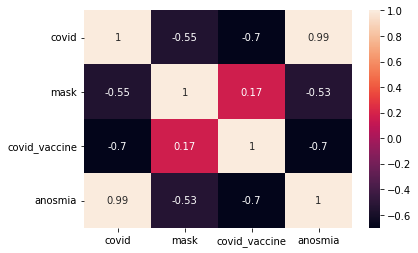

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import json


df = query_db("SELECT percent_json FROM covid_survey_json")

for indicator in INDICATORS:
  df[indicator] = df['percent_json'].apply(lambda x: json.loads(x).get(indicator))

df[INDICATORS]

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
query_db("SELECT * FROM rpl_covid_survey_tested_positive_14d")

,pct_tested_positive_14d,tested_positive_14d_se,pct_tested_positive_14d_unw,tested_positive_14d_se_unw,sample_size,country,iso_code,gid_0,survey_date
0,None,None,None,None,None,South Africa,ZAF,ZAF,20210701
1,None,None,None,None,None,Spain,ESP,ESP,20210701
2,None,None,None,None,None,Poland,POL,POL,20210701
3,None,None,None,None,None,Algeria,DZA,DZA,20210701
4,None,None,None,None,None,Argentina,ARG,ARG,20210701
5,None,None,None,None,None,Kenya,KEN,KEN,20210701
6,None,None,None,None,None,Switzerland,CHE,CHE,20210701
7,None,None,None,None,None,Japan,JPN,JPN,20210701


In [ ]:
query_db("SELECT * FROM covid_survey_json")

,percent_json,json_se,percent_json_unw,json_se_unw,json_sample_size,country,iso_code,gid_0,survey_date
0,"{""covid"": 0.004077,""mask"": 0.963163,""covid_vac...","{""covid"": 0.001014,""mask"": 0.003969,""covid_vac...","{""covid"": 0.004395,""mask"": 0.9681,""covid_vacci...","{""covid"": 0.00086,""mask"": 0.002353,""covid_vacc...","{""covid"": 5916,""mask"": 5580,""covid_vaccine"": 5...",Japan,JPN,JPN,20210701
1,"{""covid"": 0.005203,""mask"": 0.791662,""covid_vac...","{""covid"": 0.001419,""mask"": 0.008764,""covid_vac...","{""covid"": 0.005156,""mask"": 0.78265,""covid_vacc...","{""covid"": 0.001247,""mask"": 0.007352,""covid_vac...","{""covid"": 3297,""mask"": 3147,""covid_vaccine"": 3...",Germany,DEU,DEU,20210701
2,"{""covid"": 0.006898,""mask"": 0.838525,""covid_vac...","{""covid"": 0.003247,""mask"": 0.013297,""covid_vac...","{""covid"": 0.005771,""mask"": 0.827139,""covid_vac...","{""covid"": 0.001735,""mask"": 0.009184,""covid_vac...","{""covid"": 1906,""mask"": 1695,""covid_vaccine"": 1...",Vietnam,VNM,VNM,20210701
3,"{""covid"": 0.045699,""mask"": 0.894167,""covid_vac...","{""covid"": 0.010931,""mask"": 0.014362,""covid_vac...","{""covid"": 0.032218,""mask"": 0.892144,""covid_vac...","{""covid"": 0.006216,""mask"": 0.011319,""covid_vac...","{""covid"": 807,""mask"": 751,""covid_vaccine"": 776...",Venezuela,VEN,VEN,20210701
4,"{""covid"": 0.018302,""mask"": 0.881664,""covid_vac...","{""covid"": 0.008787,""mask"": 0.026141,""covid_vac...","{""covid"": 0.014388,""mask"": 0.903896,""covid_vac...","{""covid"": 0.005832,""mask"": 0.015021,""covid_vac...","{""covid"": 417,""mask"": 385,""covid_vaccine"": 397...",Uruguay,URY,URY,20210701
...,...,...,...,...,...,...,...,...,...
76,"{""covid"": 0.074094,""mask"": 0.802343,""covid_vac...","{""covid"": 0.01566,""mask"": 0.031168,""covid_vacc...","{""covid"": 0.103627,""mask"": 0.788671,""covid_vac...","{""covid"": 0.012666,""mask"": 0.019056,""covid_vac...","{""covid"": 579,""mask"": 459,""covid_vaccine"": 511...",Bangladesh,BGD,BGD,20210701
77,"{""covid"": 0.012274,""mask"": 0.725215,""covid_vac...","{""covid"": 0.005129,""mask"": 0.022226,""covid_vac...","{""covid"": 0.012024,""mask"": 0.732068,""covid_vac...","{""covid"": 0.004879,""mask"": 0.020342,""covid_vac...","{""covid"": 499,""mask"": 474,""covid_vaccine"": 484...",Austria,AUT,AUT,20210701
78,"{""covid"": 0.023942,""mask"": 0.672287,""covid_vac...","{""covid"": 0.004655,""mask"": 0.01548,""covid_vacc...","{""covid"": 0.022576,""mask"": 0.644238,""covid_vac...","{""covid"": 0.003828,""mask"": 0.012809,""covid_vac...","{""covid"": 1506,""mask"": 1397,""covid_vaccine"": 1...",Australia,AUS,AUS,20210701
79,"{""covid"": 0.016443,""mask"": 0.893224,""covid_vac...","{""covid"": 0.003064,""mask"": 0.008383,""covid_vac...","{""covid"": 0.015955,""mask"": 0.90515,""covid_vacc...","{""covid"": 0.002503,""mask"": 0.00607,""covid_vacc...","{""covid"": 2507,""mask"": 2330,""covid_vaccine"": 2...",Argentina,ARG,ARG,20210701
